In [ ]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

MessageError: ignored

In [ ]:
import os

#os.environ['CUDA_LAUNCH_BLOCKING'] = '1'


import torch, torchvision
from torch import nn
from pathlib import Path
from torchvision import datasets
import torchvision.transforms as transforms
from torchvision.transforms import RandomCrop, RandomHorizontalFlip, RandomRotation
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from timeit import default_timer as timer
from tqdm import tqdm
from typing import List, Tuple, Dict
from skimage import io, transform, color
from torchvision.transforms import functional as F

!pip install elasticdeform
import elasticdeform

import random

import cv2

from PIL import Image

import numpy as np

import multiprocessing as mp


#### To unlock to check the integrity of the dataset. Are there differences between images and masks?
"""
def checkDataset(img_path, mask_path):
  file_set1 = set()
  for dirpath, dirnames, filenames in os.walk(img_path):
    for filename in filenames:
      file_name, file_extension = os.path.splitext(filename)
      file_set1.add(file_name)

  file_set2 = set()
  for dirpath, dirnames, filenames in os.walk(mask_path):
    for filename in filenames:
      file_name, file_extension = os.path.splitext(filename)
      file_set2.add(file_name)

  # compare the sets of file names
  unique_to_folder1 = file_set1 - file_set2
  unique_to_folder2 = file_set2 - file_set1


  # print the results
  print("Files unique to folder 1:", unique_to_folder1)
  print("Files unique to folder 2:", unique_to_folder2)

"""


# Set device
device = "cuda" if torch.cuda.is_available() else "cpu"


def walk_through_dir(dir_path):
  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

data_path = Path("/content/gdrive/MyDrive/FoodSeg103/Images/")

img_dir = data_path / "img_dir"
ann_dir = data_path / "ann_dir"


# RandomCustomCrop
class RandomCustomCrop(object):

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        if isinstance(output_size, int):
            self.output_size = (output_size, output_size)
        else:
            assert len(output_size) == 2
            self.output_size = output_size

    def __call__(self, sample):

        img, mask = sample['image'], sample['mask']

        w = img.shape[0]
        h = img.shape[1]

        #print("w", w)
        #print("h", h)

        # New crop size passed in the constructor
        new_w, new_h = self.output_size

        if h == new_h and w == new_w:
            return sample

        if w < new_w or h < new_h:
            raise ValueError("Input image size is smaller than the desired crop size")
         #   #return sample

        x1 = random.randint(0, w - new_w)
        y1 = random.randint(0, h - new_h)

        # Convert to PIL Image
        img = Image.fromarray(img)
        mask = Image.fromarray(mask)

        # Crop img and mask
        img = F.crop(img, y1, x1, new_h, new_w)
        mask = F.crop(mask, y1, x1, new_h, new_w)

        # PIL to numpy array
        img = np.array(img)
        mask = np.array(mask)

        return {'image': img, 'mask': mask}


# RandomCustomRotation
class RandomCustomRotation(object):


    def __init__(self, degrees):
        self.degrees = degrees

    def __call__(self, sample):

        img, mask = sample['image'], sample['mask']

        angle = random.uniform(self.degrees[0], self.degrees[1])

        # Convert to PIL Image
        img = Image.fromarray(img)
        mask = Image.fromarray(mask)

        # Rotation
        img = F.rotate(img, angle)
        mask = F.rotate(mask, angle)

        # PIL to numpy array
        img = np.array(img)
        mask = np.array(mask)

        return {'image': img, 'mask': mask}


# RandomCustomHorizontalFlip
class RandomCustomHorizontalFlip(object):
    def __init__(self, p=0.5):
        self.p = p

    def __call__(self, sample):
        img, mask = sample['image'], sample['mask']



        if random.random() < self.p:

            # Transformation to tensors
            img = torch.from_numpy(img).float()
            mask = torch.from_numpy(mask).float()

            img = torch.flip(img, dims=[1])
            mask = torch.flip(mask, dims=[1])

            # Transform back
            img = img.numpy()
            mask = mask.numpy()

        return {'image': img, 'mask': mask}


# RandomCustomVerticalFlip
class RandomCustomVerticalFlip(object):
    def __init__(self, p=0.5):
        self.p = p

    def __call__(self, sample):
        img, mask = sample['image'], sample['mask']


        if random.random() < self.p:

            # Transformation to tensors
            img = torch.from_numpy(img).float()
            mask = torch.from_numpy(mask).float()

            img = torch.flip(img, dims=[0])
            mask = torch.flip(mask, dims=[0])

            # Transform back
            img = img.numpy()
            mask = mask.numpy()

        return {'image': img, 'mask': mask}



class RandomGaussianNoise(object):
    def __init__(self, mean=0.0, std=0.1):
      self.mean = mean
      self.std  = std

    def __call__(self, img):

      # Generate Gaussian noise with mean 0 and standard deviation 10 for each color channel
      noise = np.random.normal(0, 1, img.shape)

      # Scale the noise by a small factor (e.g., 0.05) to add a light layer of noise
      scaled_noise = 0.1 * noise

      # Add the noise to each color channel of the image
      noisy_img = np.clip(img.astype(np.int16) + scaled_noise, 0, 255).astype(np.uint8)

      img = noisy_img

      # Transform back
      #img = img.numpy()


      return img


# ElasticDeform
class ElasticDeform(object):
    def __init__(self, sigma, alpha):
        self.sigma = sigma
        self.alpha = alpha

    def __call__(self, sample):
        img, mask = sample['image'], sample['mask']


        # We add a dimension at the end
        mask = np.expand_dims(mask, axis=-1)



        # Ensure that the input image is a 3D array with shape (height, width, channels)
        assert img.ndim == 3 and img.shape[2] == 3, "Input image must be a 3D RGB array with shape (height, width, 3)"

        # Ensure that the mask is a 3D array with shape (height, width, 1)
        assert mask.ndim == 3 and mask.shape[2] == 1, "Mask must be a 3D array with shape (height, width, 1)"

        # Reshape the input image into a 2D array with shape (height * width, channels)
        height, width, channels = img.shape
        flattened_img = img.reshape(-1)

        mask_rgb = np.repeat(mask, 3, axis=-1)
        flattened_mask = mask_rgb.reshape(-1)


        # Generate a random displacement field along the width and height dimensions
        #displacement = np.random.randn(2, height, width) * self.sigma

        # Combine images and masks into a single 3D array
        combined = np.concatenate((flattened_img, flattened_mask), axis=-1)

        # Apply deformation to combined array
        deformed_combined = elasticdeform.deform_random_grid(combined,
                                                     sigma=self.sigma,
                                                     order=3,
                                                     mode='nearest'
                                                     )

        # Split deformed array back into images and masks
        deformed_reshaped_img = deformed_combined[:height*width*channels].reshape((height, width, channels))
        deformed_reshaped_mask = deformed_combined[height*width*channels:].reshape((height, width, channels))

        #Convert mask to grayscale
        deformed_reshaped_mask = np.mean(deformed_reshaped_mask, axis=-1)
        deformed_reshaped_mask = np.expand_dims(deformed_reshaped_mask, axis=-1)

        #deformed_mask = np.squeeze(deformed_reshaped_mask, axis=-1)

        deformed_img = deformed_reshaped_img
        deformed_mask = deformed_reshaped_mask

        print("deformed_img", deformed_img.shape)
        print("deformed_mask", deformed_mask.shape)

        return {'image': deformed_img, 'mask': deformed_mask}




class CustomToTensor(object):
    #Convert ndarrays in sample to Tensors.


    def __new__(self, sample):
        img, mask = sample['image'], sample['mask']

        mask = np.expand_dims(mask, axis=-1)

        # swap color axis because
        # numpy image: H x W x C
        # torch image: C x H x W
        img = img.transpose((2, 0, 1))
        mask = mask.transpose((2, 0, 1))

        return {'image': torch.from_numpy(img).float(),
                'mask': torch.from_numpy(mask).float()}


class UnNormalize(object):
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

    def __call__(self, tensor):
        """
        Args:
            tensor (Tensor): Tensor image of size (C, H, W) to be normalized.
        Returns:
            Tensor: Normalized image.
        """
        for t, m, s in zip(tensor, self.mean, self.std):
            t.mul_(s).add_(m)
            # The normalize code -> t.sub_(m).div_(s)
        return tensor


# Class SegIngredientDataset
class SegIngredientsDataset(Dataset):

    def __init__(self, img_dir, mask_dir, path, img_transform, mask_transform, common_transform, eval):

        self.eval = eval

        self.img_dir = img_dir / path
        self.mask_dir = mask_dir / path

        self.img_transform = img_transform
        self.mask_transform = mask_transform
        self.common_transform = common_transform

        print(self.img_dir)

        # Traverses and prints directory details
        #walk_through_dir(img_dir)

        #walk_through_dir(mask_dir)

        self.img_list = []
        self.mask_list = []

        self.dirs = [self.img_dir, self.mask_dir]

        self.num_processes = min(mp.cpu_count(), len(self.dirs))

    # Return the instance
    def Get(self):
        return self

    # Method called by the processs to do parallelization
    def run(self, obj):
        pool = mp.Pool(self.num_processes)

        pool.daemon = False

        manager = mp.Manager()
        p_img_list = manager.list()
        p_mask_list = manager.list()

        pool.starmap(self.read_files_from_folder, [(self.img_dir, p_img_list, cv2.IMREAD_COLOR), (self.mask_dir, p_mask_list, cv2.IMREAD_GRAYSCALE)])

        self.img_list = p_img_list
        self.mask_list = p_mask_list

        pool.close()
        pool.join()

    # Subprocess reading in the 2 different folders at the same time
    def read_files_from_folder(self, folder_path, custom_list, imread_type):
        counter = 0
        for entry in sorted(os.scandir(folder_path), key=lambda e: e.name):
            if entry.is_file():
              img_path = entry.path

              img_open = Image.open(img_path)
              img_open = img_open.resize((256, 256), resample=Image.NEAREST)

              img_array = np.array(img_open)
              custom_list.append(img_array)
              #print(filename, " | ", np.unique(img_array))
              print(img_path)


            #counter = counter + 1
            #if(counter >17):
            #  break


    def __len__(self):
        return len(self.img_list)

    def __getitem__(self, idx):

        img = self.img_list[idx]
        y = self.mask_list[idx]


        # Create sample array to perform modifications simultaneously on both images and masks
        sample = {}
        sample['image'] = img
        sample['mask'] = y



        if(self.eval):
          sample_transformed = CustomToTensor(sample)
          img = sample_transformed['image']
          y = sample_transformed['mask']


          return img, y

        if self.img_transform and self.mask_transform and self.common_transform is not None:

            # Perform modifications together
            sample_transformed = self.common_transform(sample)
            img = sample_transformed['image']
            y = sample_transformed['mask']

            img = self.img_transform(img)
            y = self.mask_transform(y)


        return img, y


# Parallelization

from multiprocessing import Process, Manager
from multiprocessing.managers import BaseManager

BaseManager.register('SegIngredientsDataset', SegIngredientsDataset)
manager = BaseManager()
manager.start()

#####
#Transformations
#########


#Normalization image

img_mean = [0.485, 0.456, 0.406]
img_std = [0.229, 0.224, 0.225]


#RandomGaussianNoise(mean=0.0, std=1.0),
img_transform = transforms.Compose([

    transforms.ToTensor(),
    transforms.Normalize(img_mean, img_std)
])

# Mask transform
mask_transform = transforms.Compose([
    transforms.ToTensor(),
])

# Common transform
#RandomCustomCrop((200,200)),
#RandomCustomRotation(degrees=(-50, 50)),

#RandomCustomVerticalFlip(),
#ElasticDeform(sigma=0.1, alpha=30),
common_transform = transforms.Compose([

    RandomCustomRotation(degrees=(-50, 50)),
    RandomCustomHorizontalFlip(),

])


# Classes handled by the process manager

train_data = manager.SegIngredientsDataset(img_dir = img_dir, mask_dir = ann_dir, path = "train/", img_transform=img_transform, mask_transform=mask_transform, common_transform=common_transform, eval=False)
test_data  = manager.SegIngredientsDataset(img_dir = img_dir, mask_dir = ann_dir, path = "test/", img_transform=img_transform, mask_transform=mask_transform, common_transform=common_transform, eval=True)

process1 = mp.Process(target=train_data.run, args=[train_data])
process2 = mp.Process(target=test_data.run, args=[test_data])
process1.start()
process2.start()

process1.join()
process2.join()

# Retrieve the 2 datasets (train and test)
train_1 = train_data.Get()
test_1 = test_data.Get()


Streaming output truncated to the last 5000 lines.
/content/gdrive/MyDrive/FoodSeg103/Images/img_dir/train/00002374.jpg
/content/gdrive/MyDrive/FoodSeg103/Images/ann_dir/train/00002600.png
/content/gdrive/MyDrive/FoodSeg103/Images/ann_dir/train/00002601.png
/content/gdrive/MyDrive/FoodSeg103/Images/img_dir/train/00002375.jpg
/content/gdrive/MyDrive/FoodSeg103/Images/ann_dir/train/00002602.png
/content/gdrive/MyDrive/FoodSeg103/Images/img_dir/train/00002376.jpg
/content/gdrive/MyDrive/FoodSeg103/Images/ann_dir/train/00002603.png
/content/gdrive/MyDrive/FoodSeg103/Images/img_dir/train/00002377.jpg
/content/gdrive/MyDrive/FoodSeg103/Images/ann_dir/train/00002604.png
/content/gdrive/MyDrive/FoodSeg103/Images/img_dir/train/00002378.jpg
/content/gdrive/MyDrive/FoodSeg103/Images/ann_dir/train/00002605.png
/content/gdrive/MyDrive/FoodSeg103/Images/img_dir/train/00002379.jpg
/content/gdrive/MyDrive/FoodSeg103/Images/ann_dir/train/00002606.png
/content/gdrive/MyDrive/FoodSeg103/Images/ann_dir/tr

In [ ]:
# Calculate pixel accuracy
def calculate_pixel_accuracy(y_truth, y_pred):

    matched_pixels = (y_truth == y_pred).sum().item()
    total_pixels = y_truth.nelement()
    #print("matched pixels", matched_pixels)
    match_ = (matched_pixels / total_pixels)

    return match_



Feature batch shape: torch.Size([4, 3, 256, 256])
Labels batch shape: torch.Size([4, 1, 256, 256])
torch.Size([3, 256, 256])


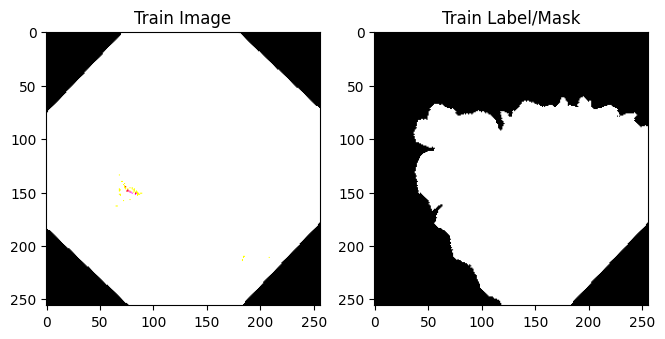

In [ ]:
# We create a train_loader by passing the train dataset
train_loader = torch.utils.data.DataLoader(dataset = train_1,
                                            batch_size = 4,
                                            shuffle = True,
                                            drop_last=True) #shuffle ensures we traverse images in different order across epochs


# Display image and label. Checking if everything is fine
train_features, train_labels = next(iter(train_loader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")

# Remove extra dimension (batch)
img = train_features[0].squeeze()
label = train_labels[0].squeeze()
print(img.size())

#print(label)


# Unnormalize the data so it appears clearly:

img_unnorm = UnNormalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
#mask_unnorm = UnNormalize(mean=(0.5,), std=(0.5,))

img_new = img_unnorm(img)
#mask_unnorm = mask_unnorm(label)

img_new = img_new.permute(1,2,0)

#print(img_new)





# normalize the tensor values to the range [0, 255]
img_new = img_new * 255.0

# convert the tensor to a numpy array
img_new = img_new.clamp(0, 255).byte().numpy()

#print(img_new)

"""
Label

"""

# normalize the tensor values to the range [0, 255]
label_new = label * 255.0

# convert the tensor to a numpy array
label_new = label_new.clamp(0, 255).byte().numpy()

#print(label_new)


plt.figure(figsize=(12, 8))
plt.subplot(231)
plt.title('Train Image')
plt.imshow(img_new)
plt.subplot(232)
plt.title('Train Label/Mask')
plt.imshow(label_new, cmap="gray")

plt.show()


del train_loader


In [ ]:
#if not FIRST_RUN:
#  del train_step

def train_step(model: torch.nn.Module, dataloader: torch.utils.data.DataLoader, loss_fn: torch.nn.Module,
optimizer: torch.optim.Optimizer):
  total_train = 0
  correct_train = 0
# Put model in train mode
  model.train()
# Setup train loss and train accuracy values
  train_loss, train_acc, train_miou_acc_all, train_dice_acc, train_miou_acc_ibg, train_iou_background = 0, 0, 0, 0, 0, 0
# Loop through data loader data batches
  for batch, (X, y) in enumerate(dataloader):

    y = y.squeeze(dim=1)
    y = y.type(torch.LongTensor)
    #X = X.float()

    #print("y", y.shape )


# Send data to target device
    X, y = X.to(device), y.to(device)
# 1. Forward pass
    y_pred = model(X)
    #print("y pred shape", y_pred.shape)
# 2. Calculate and accumulate loss
    loss = loss_fn(y_pred, y)
    train_loss += loss.item()
# 3. Optimizer zero grad
    optimizer.zero_grad()
# 4. Loss backward
    loss.backward()
# 5. Optimizer step
    optimizer.step()
# Calculate and accumulate accuracy metric across all batches

    predicted = torch.argmax(y_pred, 1)

    train_acc += calculate_pixel_accuracy(y, predicted)

    train_tp, train_fp, train_fn, train_tn = smp.metrics.get_stats(predicted, y, mode='multiclass', num_classes=104)
    train_miou_acc_all += smp.metrics.iou_score(train_tp, train_fp, train_fn, train_tn, reduction="micro").item()
    train_dice_acc += smp.metrics.f1_score(train_tp, train_fp, train_fn, train_tn, reduction="micro").item()

    predicted_i = predicted.clone() - 1
    y_i = y.clone() - 1

    train_tp_i, train_fp_i, train_fn_i, train_tn_i = smp.metrics.get_stats(predicted_i, y_i, mode='multiclass', num_classes=104, ignore_index=-1)
    train_miou_acc_ibg += smp.metrics.iou_score(train_tp_i, train_fp_i, train_fn_i, train_tn_i, reduction="micro").item()




# Adjust metrics to get average loss and accuracy per batch
  train_loss = train_loss / len(dataloader)

  train_acc = train_acc / len(dataloader)

  train_miou_acc_all = train_miou_acc_all / len(dataloader)
  train_dice_acc = train_dice_acc / len(dataloader)

  train_miou_acc_ibg = train_miou_acc_ibg / len(dataloader)

  train_iou_background = train_miou_acc_all - train_miou_acc_ibg


  return train_loss, train_acc, train_miou_acc_all, train_dice_acc, train_miou_acc_ibg, train_iou_background


In [ ]:
#if not FIRST_RUN:
#  del test_step

def test_step(model: torch.nn.Module,
    dataloader: torch.utils.data.DataLoader,
    loss_fn: torch.nn.Module):

  total_test = 0
  correct_test = 0
# Put model in eval mode
  model.eval()
# Setup test loss and test accuracy values
  test_loss, test_acc, test_miou_acc_all, test_dice_acc, test_miou_acc_ibg, test_iou_background = 0, 0, 0, 0, 0, 0
# Turn on no_grad context manager
  with torch.no_grad():
# Loop through DataLoader batches
    for batch, (X, y) in enumerate(dataloader):

      y = y.squeeze(dim=1)
      y = y.type(torch.LongTensor)

# Send data to target device
      X, y = X.to(device), y.to(device)
# 1. Forward pass
      test_pred_logits = model(X)
# 2. Calculate and accumulate loss
      loss = loss_fn(test_pred_logits, y)
      test_loss += loss.item()
# Calculate and accumulate accuracy

      predicted = torch.argmax(test_pred_logits, 1)

      test_acc += calculate_pixel_accuracy(y, predicted)

      test_tp, test_fp, test_fn, test_tn = smp.metrics.get_stats(predicted, y, mode='multiclass', num_classes=104)
      test_miou_acc_all += smp.metrics.iou_score(test_tp, test_fp, test_fn, test_tn, reduction="micro").item()
      test_dice_acc += smp.metrics.f1_score(test_tp, test_fp, test_fn, test_tn, reduction="micro").item()

      predicted_i = predicted.clone() - 1
      y_i = y.clone() - 1

      test_tp_i, test_fp_i, test_fn_i, test_tn_i = smp.metrics.get_stats(predicted_i, y_i, mode='multiclass', num_classes=104, ignore_index=-1)
      test_miou_acc_ibg += smp.metrics.iou_score(test_tp_i, test_fp_i, test_fn_i, test_tn_i, reduction="micro").item()




# Adjust metrics to get average loss and accuracy per batch
  test_loss = test_loss / len(dataloader)

  test_acc = test_acc / len(dataloader)

  test_miou_acc_all = test_miou_acc_all / len(dataloader)
  test_dice_acc = test_dice_acc / len(dataloader)

  test_miou_acc_ibg = test_miou_acc_ibg / len(dataloader)

  test_iou_background = test_miou_acc_all - test_miou_acc_ibg

  return test_loss, test_acc, test_miou_acc_all, test_dice_acc, test_miou_acc_ibg, test_iou_background


In [ ]:
#if not FIRST_RUN:
#  del save_training_checkpoint
#  del save_results_in_file
#  del train

import json

# Function to save pth files to google drive
def save_training_checkpoint(state, filename):
    path = F"/content/gdrive/MyDrive/Thesis_deeplearning_models/{filename}.pth"
    torch.save(state, path)

# Function to save results into a file
def save_results_in_file(dic_results, hyperparameters):
  link = "/content/gdrive/MyDrive/Thesis_deeplearning_models/results_bo_v" + str(hyperparameters.VERSION_EXPERIMENT) + ".txt"
  with open(link, 'a') as f:
    json.dump(dic_results, f)
    f.write('\n')


# Define a custom encoder that skips over non-serializable attributes
class CustomEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, property):
            return None
        return super().default(obj)


def save_hyperparameters_in_file(hyperparameters):
  # Convert the class variables to a dictionary
  table_dict = {"VERSION_EXPERIMENT": hyperparameters.VERSION_EXPERIMENT,
                "OPTIMIZER": hyperparameters.OPTIMIZER,
                "ARCHITECTURE_USED" : hyperparameters.ARCHITECTURE_USED,
                "NETWORK": hyperparameters.NETWORK,
                "BATCH_SIZE": hyperparameters.BATCH_SIZE,
                "LEARNING_RATE": hyperparameters.LEARNING_RATE,
                "MOMENTUM": hyperparameters.MOMENTUM,
                "WEIGHT_DECAY": hyperparameters.WEIGHT_DECAY,
                "LOSS_FUNCTION" : hyperparameters.LOSS_FUNCTION,
                "NUM_EPOCHS": hyperparameters.NUM_EPOCHS
                }

  # Serialize the dictionary to a JSON string
  json_string = json.dumps(table_dict, indent=4)
  json_string_comma = "," + json_string
  link = "/content/gdrive/MyDrive/Thesis_deeplearning_models/hyperparameters_versions.txt"

  # Write the JSON string to a text file
  with open(link, "a") as f:
      f.write(json_string_comma)



def train(model: torch.nn.Module, train_dataloader: torch.utils.data.DataLoader, test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer, hyperparameters, loss_fn: torch.nn.Module = nn.CrossEntropyLoss(), epochs: int = 5):
    # 2. Create empty results dictionary
    results = {"train_loss": [],
        "train_acc": [],
        "train_miou_acc_all": [],
        "train_dice_acc" : [],
        "train_miou_acc_ibg" : [],
        "train_iou_background": [],
        "test_loss": [],
        "test_acc": [],
        "test_miou_acc_all": [],
        "test_dice_acc": [],
        "test_miou_acc_ibg" : [],
        "test_iou_background": [],
        "learning_rate": [],
    }

    results_line = {
        "epoch": 0,
        "train_loss": 0,
        "train_acc": 0,
        "train_miou_acc_all": 0,
        "train_dice_acc" : 0,
        "train_miou_acc_ibg" : 0,
        "train_iou_background": 0,
        "test_loss": 0,
        "test_acc": 0,
        "test_miou_acc_all": 0,
        "test_dice_acc": 0,
        "test_miou_acc_ibg" : 0,
        "test_iou_background": 0,
        "learning_rate": 0,
    }

    # Save hyperparameters in a file
    save_hyperparameters_in_file(hyperparameters)

    # 3. Loop through training and testing steps for a number of epochs
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc, train_miou_acc_all, train_dice_acc, train_miou_acc_ibg, train_iou_background = train_step(model=model,dataloader=train_dataloader, loss_fn=loss_fn, optimizer=optimizer)
        test_loss, test_acc, test_miou_acc_all, test_dice_acc, test_miou_acc_ibg, test_iou_background = test_step(model=model, dataloader=test_dataloader, loss_fn=loss_fn)

        #current_lr = scheduler.get_last_lr()[0]
        #scheduler.step()
        current_lr = hyperparameters.LEARNING_RATE


        # 4. Print loss & accuracies
        print(
            f"Epoch: {epoch+1} | "
            f"train_loss: {train_loss:.4f} | "
            f"train_acc: {train_acc:.4f} | "
            f"train_miou_acc_all: {train_miou_acc_all:.4f} | "
            f"train_dice_acc: {train_dice_acc:.4f} | "
            f"train_miou_acc_ibg: {train_miou_acc_ibg:.4f} | "
            f"train_iou_background: {train_iou_background:.4f} | "
            f"test_loss: {test_loss:.4f} | "
            f"test_acc: {test_acc:.4f} | "
            f"test_miou_acc_all: {test_miou_acc_all:.4f} | "
            f"test_dice_acc: {test_dice_acc:.4f} | "
            f"test_miou_acc_ibg: {test_miou_acc_ibg:.4f} | "
            f"test_iou_background: {test_iou_background:.4f} | "
            f"learning_rate: {current_lr:.4f} | "
        )
        # 5. Update results dictionary
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["train_miou_acc_all"].append(train_miou_acc_all)
        results["train_dice_acc"].append(train_dice_acc)
        results["train_miou_acc_ibg"].append(train_miou_acc_ibg)
        results["train_iou_background"].append(train_iou_background)

        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)
        results["test_miou_acc_all"].append(test_miou_acc_all)
        results["test_dice_acc"].append(test_dice_acc)
        results["test_miou_acc_ibg"].append(test_miou_acc_ibg)
        results["test_iou_background"].append(test_iou_background)

        results["learning_rate"].append(current_lr)


        # Save model continuously :

        file_checkpoint_exp = 'checkpoint_random_v' + str(hyperparameters.VERSION_EXPERIMENT) + '_{}'
        file_checkpoint = file_checkpoint_exp.format(epoch+1)

        if(test_miou_acc_ibg >= 0.27 or test_miou_acc_all >= 0.48 ):
            save_training_checkpoint({
                'epoch': epoch+1,
                'state_dict': model.state_dict(),
                'optimizer': optimizer.state_dict(),
            }, file_checkpoint,
            )


        # Update results_line dictionary

        results_line["epoch"] = epoch+1

        results_line["train_loss"] = train_loss
        results_line["train_acc"] = train_acc
        results_line["train_miou_acc_all"] = train_miou_acc_all
        results_line["train_dice_acc"] = train_dice_acc
        results_line["train_miou_acc_ibg"] = train_miou_acc_ibg
        results_line["train_iou_background"] = train_iou_background

        results_line["test_loss"] = test_loss
        results_line["test_acc"] = test_acc
        results_line["test_miou_acc_all"] = test_miou_acc_all
        results_line["test_dice_acc"] = test_dice_acc
        results_line["test_miou_acc_ibg"] = test_miou_acc_ibg
        results_line["test_iou_background"] = test_iou_background

        results_line["learning_rate"] = current_lr

        # Save data results in a file
        save_results_in_file(results_line, hyperparameters)


    # 6. Return the filled results at the end of the epochs
    return results


In [ ]:
import torchvision.models as models
from torchvision.models.segmentation.deeplabv3 import DeepLabHead

#!pip install focal_loss_torch
#from focal_loss.focal_loss import FocalLoss

!pip install segmentation-models-pytorch
import segmentation_models_pytorch as smp

from torch.optim.lr_scheduler import StepLR


# Botorch bayesian optimization

!pip install botorch



import botorch
from botorch.models import SingleTaskGP
from botorch.utils import standardize
from botorch.acquisition import UpperConfidenceBound
from botorch.acquisition import ExpectedImprovement
from botorch.sampling import SobolQMCNormalSampler
from botorch.acquisition import qNoisyExpectedImprovement
from botorch.optim import optimize_acqf

from gpytorch.mlls.exact_marginal_log_likelihood import ExactMarginalLogLikelihood
from botorch import fit_gpytorch_model
from botorch.acquisition.monte_carlo import qExpectedImprovement


"""
HYPERPARAMETER SETTINGS
"""


class Hyperparameters:
    def __init__(self, version_experiment, optimizer, architecture_used, network, batch_size, learning_rate, momentum, weight_decay, loss_function, num_epochs):
        self.VERSION_EXPERIMENT = version_experiment
        self.OPTIMIZER = optimizer
        self.ARCHITECTURE_USED = architecture_used
        self.NETWORK = network
        self.BATCH_SIZE = batch_size
        self.LEARNING_RATE = learning_rate
        self.MOMENTUM = momentum
        self.WEIGHT_DECAY = weight_decay
        self.LOSS_FUNCTION = loss_function
        self.NUM_EPOCHS = num_epochs



def process_experiment(experiment):
    # Convert keys to lowercase
    experiment = {k.lower(): v for k, v in experiment.items()}
    return experiment


def extractVersionFromRSFileName(filename_random_search):

    # Find the position of the underscore before the version
    underscore_index = filename_random_search.rfind("v")

    # Extract the version substring
    version = filename_random_search[underscore_index + 1 : -4]

    return version


"""
    Reverse mapping function, takes the numerical value as well as the hyperparameter concerned in input,
    and returns the original value
"""
def reverse_mapping(hyperparameter, value_to_reverse):
    features_table = original_bound_values[hyperparameter]
    # Create a dictionary to map batch sizes to integer values
    size_mapping = {size: idx for idx, size in enumerate(features_table)}

    # Reverse the key-value pairs in size_mapping
    reversed_size_mapping = {idx: size for size, idx in size_mapping.items()}

    value_to_reverse = round(value_to_reverse)
    return reversed_size_mapping[value_to_reverse]



"""
From here, the data can be reloaded and variables destroyed to carry out multiple runs
"""
FIRST_RUN = True

# Number of experiments
num_experiments = 50

# start index
start_index = 2044

"""
LOOP STARTING
"""
for rs_experiment in range(start_index, start_index + num_experiments):



  data_path = Path("/content/gdrive/MyDrive/Thesis_deeplearning_models/")
  filename_hyperparameters_experiments = data_path / 'hyperparameters_versions.txt'

  # Read the file starting at experiment 1000

  hyperparameters_experiments = []

  # Read the contents of the file
  with open(filename_hyperparameters_experiments, 'r') as file:
    content = file.read()


  content = "[" + content + "]"

  # Parse the content as JSON
  hyperparameters_experiments = json.loads(content)

  # Filter experiments with version below 1000
  hyperparameters_experiments = [hyperparameters_experiment for hyperparameters_experiment in hyperparameters_experiments if hyperparameters_experiment["VERSION_EXPERIMENT"] >= 1000]

  # Transform keys to lowercase and remove specified keys
  filtered_hyperparameters_experiments = []
  for hyperparameters in hyperparameters_experiments:
      filtered_hyperparameters = {key.lower(): value for key, value in hyperparameters.items() if key not in ["NUM_EPOCHS"]}
      filtered_hyperparameters_experiments.append(filtered_hyperparameters)



  # Remove first duplicates
  seen = set()
  result = []
  for filtered_hyperparameters in filtered_hyperparameters_experiments:
      if filtered_hyperparameters["version_experiment"] not in seen:
          seen.add(filtered_hyperparameters["version_experiment"])
          result.append(filtered_hyperparameters)


  filtered_hyperparameters_experiments = result





  """

  """


  # We retrieve all the txt files in the folder
  file_list = []

  for root, dirs, files in os.walk(data_path):
      for file in files:
          if file.startswith('results_randomsearch') or file.startswith('results_bo'):
              file_path = os.path.join(root, file)
              file_list.append(file_path)

  print(file_list)


  experiments = []

  # Loop through the files

  for file_path in file_list:

      adapted_filename = "modified_data_v" + extractVersionFromRSFileName(file_path) + ".txt"
      test_post = data_path / adapted_filename

      # Read the text file
      with open(file_path, 'r') as file:
          content = file.read()

      # Add "[" at the beginning and "]" at the end
      content = '[' + content + ']'

      # Add delimiter "," between each symbol "}{"
      content = content.replace('}\n{', '},{')

      # Save the modified content to a new text file
      with open(test_post, 'w') as file:
          file.write(content)



      """
          read modified file && update the table
      """


      with open(test_post, 'r') as file:
          content_transformed = file.read()

      data_experiment = json.loads(content_transformed)

      for epoch in data_experiment:
          experiments.append(
            {
                "version_experiment": int(extractVersionFromRSFileName(file_path)),
                "epoch": epoch["epoch"],
                "test_miou_acc_ibg": epoch["test_miou_acc_ibg"],
                "test_miou_acc_all": epoch["test_miou_acc_all"]

            }
          )



  """
      Combining the 2 arrays to prepare the data for bayesian optimization
  """

  for filtered_hyperparameters in filtered_hyperparameters_experiments:
      current_version = filtered_hyperparameters["version_experiment"]

      current_optimizer = filtered_hyperparameters["optimizer"]
      current_architecture_used = filtered_hyperparameters["architecture_used"]
      current_network = filtered_hyperparameters["network"]
      current_batch_size = filtered_hyperparameters["batch_size"]
      current_learning_rate = filtered_hyperparameters["learning_rate"]
      current_momentum = filtered_hyperparameters["momentum"]
      current_weight_decay = filtered_hyperparameters["weight_decay"]
      current_loss_function = filtered_hyperparameters["loss_function"]


      for experiment in experiments:

          if current_version == experiment["version_experiment"]:


              experiment["optimizer"] = current_optimizer
              experiment["architecture_used"] = current_architecture_used
              experiment["network"] = current_network
              experiment["batch_size"] = current_batch_size
              experiment["learning_rate"] = current_learning_rate
              experiment["momentum"] = current_momentum
              experiment["weight_decay"] = current_weight_decay
              experiment["loss_function"] = current_loss_function




  count = 0
  for exp in experiments:
      count = count + 1



  print("number of total rows " + str(count))



  # Printing data in txt_file
  """
    Posting the table into a txt file
  """

  post_training_data_file = data_path / "training_data_opti.txt"

  with open(post_training_data_file, 'w') as file:
      # Write the experiments to the file using json.dump
      json.dump(experiments, file)
      file.write('\n')





  """
    TEST running bayesian opti part
  """




  data_path_bayesian_opti = Path("/content/gdrive/MyDrive/Thesis_deeplearning_models/")

  filename_training_bayesian_opti = data_path_bayesian_opti / "training_data_opti.txt"

  # Read the contents of the file
  with open(filename_training_bayesian_opti, 'r') as file:
      content = file.read()

  # Parse the content as JSON
  training_data_bayesian_opti = json.loads(content)

  import numpy as np




  original_bound_values = {
      'optimizer':['SGD', 'Adam'],
      'architecture_used': ['DeepLabV3'],
      'network': ['resnet18'],
      'batch_size': [4,8,16],
      'momentum': [0.9],
      'loss_function': ['CrossEntropyLoss']

  }


  transformed_bound_values = {}
  training_data_bayesian_opti_modified = training_data_bayesian_opti.copy()
  valid_rows = []


  """
      Transform the original values into values that can be processed by the model
  """
  for row_training_data_modified in training_data_bayesian_opti_modified:
      ok = True
      for key in original_bound_values:
          features_table = original_bound_values[key]
          # Create a dictionary to map batch sizes to integer values
          size_mapping = {size: idx for idx, size in enumerate(features_table)}

          # Perform integer encoding on the dataset
          encoded_data = [size_mapping[features] for features in features_table]
          tuple_encoded_data = (encoded_data[0], encoded_data[-1])
          # Updates the values to numerical ones
          transformed_bound_values[key] = tuple_encoded_data

          if row_training_data_modified[key] in size_mapping:
              row_training_data_modified[key] = size_mapping[row_training_data_modified[key]]
          else:
              ok = False


      if(ok == True):
          valid_rows.append(row_training_data_modified)


  training_data_bayesian_opti_modified = valid_rows



  countb = 0
  for features_row_modified in training_data_bayesian_opti_modified:
  #   print(features_row_modified)
      countb+=1
  print("Number of valid rows : " + str(countb))


  # Define the bounds for each hyperparameter
  bounds = [
      (1,30),                                             # What is the best epoch between 1 and 30? We ran experiments between 10 and 30.
      transformed_bound_values['optimizer'],              # optimizer: 0 for 'SGD', 1 for 'Adam'
      transformed_bound_values['architecture_used'],      # architecture_used: 0 for 'DeepLabV3'
      transformed_bound_values['network'],                # network: 0 for 'resnet18'
      transformed_bound_values['batch_size'],             # batch_size: 0 for 4, 1 for 8, 2 for 16
      (0.0001, 0.9),                                      # learning_rate
      transformed_bound_values['momentum'],               # momentum: 0.9 (fixed value)
      (0.0001, 0.9),                                      # weight_decay
      transformed_bound_values['loss_function'],          # loss_function: 0 for 'CrossEntropyLoss', 1 for 'Focal Loss', 2 'Dice Loss'
  ]



  X = torch.tensor([[features_row['epoch'], features_row['optimizer'], features_row['architecture_used'],
      features_row['network'], features_row['batch_size'], features_row['learning_rate'],
      features_row['momentum'], features_row['weight_decay'], features_row['loss_function']]
      for features_row in training_data_bayesian_opti_modified], dtype=torch.double)



  y_ibg = torch.tensor([[features_row['test_miou_acc_all']] for features_row in training_data_bayesian_opti_modified])

  X = torch.tensor(X, dtype=torch.double)
  y_ibg = torch.tensor(y_ibg, dtype=torch.double)

  best_observed_y_ibg = y_ibg.max().item()
  print("best observed value for y_ibg " + str(best_observed_y_ibg))

  """

  """

  bounds = np.array(bounds)
  # Reshape the bounds to a 2 x 9 tensor
  bounds = bounds.T
  # Convert the bounds NumPy array to a PyTorch tensor
  bounds = torch.tensor(bounds)

  # SingleTaskGP model
  model_ibg = SingleTaskGP(X, y_ibg)

  # Define the acquisition function to maximize (e.g., Upper Confidence Bound)
  #acq_func = UpperConfidenceBound(model_ibg, beta=0.1)


  mll = ExactMarginalLogLikelihood(model_ibg.likelihood,model_ibg)
  fit_gpytorch_model(mll)

  acq_func = qExpectedImprovement(model_ibg, best_f=best_observed_y_ibg)


  # Optimize the hyperparameters based on the defined acquisition function
  best_hyperparameters_ibg, _ = optimize_acqf(
      acq_function=acq_func,
      bounds=bounds,
      q=1,
      num_restarts=1000,
      raw_samples=1024,
  )



  # Change the tensor to a list
  best_operational_hyperparameters = best_hyperparameters_ibg.tolist()[0]



  best_operational_hyperparameters = {
      'epoch': round(best_operational_hyperparameters[0]),
      'optimizer': reverse_mapping("optimizer",best_operational_hyperparameters[1]),
      'architecture_used': reverse_mapping("architecture_used",best_operational_hyperparameters[2]),
      'network': reverse_mapping("network",best_operational_hyperparameters[3]),
      'batch_size': reverse_mapping("batch_size",best_operational_hyperparameters[4]),
      'learning_rate': best_operational_hyperparameters[5],
      'momentum': reverse_mapping("momentum",best_operational_hyperparameters[6]),
      'weight_decay': best_operational_hyperparameters[7],
      'loss_function': reverse_mapping("loss_function",best_operational_hyperparameters[8])

}

  print(best_operational_hyperparameters)



  """
    Pre-training transformation
  """
  hyperparams = best_operational_hyperparameters
  hyperparams['num_epochs'] = hyperparams['epoch']


  """
    Training run
  """

  hyperparameters = Hyperparameters(
      rs_experiment,
      hyperparams['optimizer'],
      hyperparams['architecture_used'],
      hyperparams['network'],
      hyperparams['batch_size'],
      hyperparams['learning_rate'],
      hyperparams['momentum'],
      hyperparams['weight_decay'],
      hyperparams['loss_function'],
      hyperparams['num_epochs'],

  )

  print("Version", rs_experiment)
  print("Optimizer", hyperparams['optimizer'])
  print("Architecture", hyperparams['architecture_used'])
  print("Network", hyperparams['network'])
  print("Batch size", hyperparams['batch_size'])
  print("Learning Rate", hyperparams['learning_rate'])
  print("Momentum", hyperparams['momentum'])
  print("Weight Decay", hyperparams['weight_decay'])
  print("Loss function", hyperparams['loss_function'])
  print("Num epochs", hyperparams['num_epochs'])


  # We create a train_loader by passing the train dataset
  train_loader = torch.utils.data.DataLoader(dataset = train_1,
                                            batch_size = hyperparameters.BATCH_SIZE,
                                            shuffle = True,
                                            drop_last=True) #shuffle ensures we traverse images in different order across epochs

  # We create a test loader by passing the test dataset
  test_loader = torch.utils.data.DataLoader(dataset = test_1,
                                            batch_size = hyperparameters.BATCH_SIZE,
                                            shuffle = False,
                                            drop_last=True) #we don't do shuffle here because we only do 1 forward pass



  # Setup loss
  if(hyperparameters.LOSS_FUNCTION == "CrossEntropyLoss"):
      print("CrossEntropyLoss")
      loss_fn = nn.CrossEntropyLoss()

      if(hyperparameters.ARCHITECTURE_USED == "DeepLabV3"):
          print("DeepLabV3 no activation")
          model = smp.DeepLabV3(encoder_name=hyperparameters.NETWORK,
            encoder_depth=5,
            encoder_weights='imagenet',
            decoder_channels=256,
            in_channels=3,
            classes=104,
            activation=None,
            upsampling=8,
            aux_params=None)

      if(hyperparameters.ARCHITECTURE_USED == "Unet"):
          print("Unet no activation")
          model = smp.Unet(encoder_name=hyperparameters.NETWORK,
            encoder_depth=5,
            encoder_weights='imagenet',
            decoder_use_batchnorm=True,
            decoder_channels=(256, 128, 64, 32, 16),
            decoder_attention_type=None,
            in_channels=3,
            classes=104,
            activation=None,
            aux_params=None)


  if(hyperparameters.LOSS_FUNCTION == "FocalLoss"):
      print("FocalLoss")
      loss_fn = smp.losses.FocalLoss(mode='multiclass', gamma=0.7)

      if(hyperparameters.ARCHITECTURE_USED == "DeepLabV3"):
          print("DeepLabV3 softmax activation")
          model = smp.DeepLabV3(encoder_name=hyperparameters.NETWORK,
            encoder_depth=5,
            encoder_weights='imagenet',
            decoder_channels=256,
            in_channels=3,
            classes=104,
            activation='softmax',
            upsampling=8,
            aux_params=None)

      if(hyperparameters.ARCHITECTURE_USED == "Unet"):
          print("Unet softmax activation")
          model = smp.Unet(encoder_name=hyperparameters.NETWORK,
            encoder_depth=5,
            encoder_weights='imagenet',
            decoder_use_batchnorm=True,
            decoder_channels=(256, 128, 64, 32, 16),
            decoder_attention_type=None,
            in_channels=3,
            classes=104,
            activation='softmax',
            aux_params=None)


  if(hyperparameters.LOSS_FUNCTION == "DiceLoss"):
      print("DiceLoss")
      loss_fn = smp.losses.DiceLoss(mode='multiclass', classes=list(range(1, 104)),
                              log_loss=False,
                              from_logits=True,
                              smooth=0.0,
                              ignore_index=None,
                              eps=1e-07)


      if(hyperparameters.ARCHITECTURE_USED == "DeepLabV3"):
          print("DeepLabV3 softmax activation")
          model = smp.DeepLabV3(encoder_name=hyperparameters.NETWORK,
            encoder_depth=5,
            encoder_weights='imagenet',
            decoder_channels=256,
            in_channels=3,
            classes=104,
            activation='softmax',
            upsampling=8,
            aux_params=None)

      if(hyperparameters.ARCHITECTURE_USED == "Unet"):
          print("Unet softmax activation")
          model = smp.Unet(encoder_name=hyperparameters.NETWORK,
            encoder_depth=5,
            encoder_weights='imagenet',
            decoder_use_batchnorm=True,
            decoder_channels=(256, 128, 64, 32, 16),
            decoder_attention_type=None,
            in_channels=3,
            classes=104,
            activation='softmax',
            aux_params=None)




  # Setup optimizer
  # SGD
  if(hyperparameters.OPTIMIZER == "SGD"):

      """if(hyperparameters.MOMENTUM == None and hyperparameters.WEIGHT_DECAY != None):
          print("sgd momentum none")
          optimizer = torch.optim.SGD(model.parameters(), lr=hyperparameters.LEARNING_RATE,
                                                         weight_decay=hyperparameters.WEIGHT_DECAY)

      if(hyperparameters.WEIGHT_DECAY == None and hyperparameters.MOMENTUM != None):
          print("sgd weight decay none")
          optimizer = torch.optim.SGD(model.parameters(), lr=hyperparameters.LEARNING_RATE,
                                                        momentum=hyperparameters.MOMENTUM)

      if(hyperparameters.MOMENTUM == None and hyperparameters.WEIGHT_DECAY == None):
          print("sgd momentum none - weight decay none")
          optimizer = torch.optim.SGD(model.parameters(), lr=hyperparameters.LEARNING_RATE)

      if(hyperparameters.MOMENTUM != None and hyperparameters.WEIGHT_DECAY != None):
      """
      optimizer = torch.optim.SGD(model.parameters(), lr=hyperparameters.LEARNING_RATE,
                                                          momentum=hyperparameters.MOMENTUM,
                                                          weight_decay=hyperparameters.WEIGHT_DECAY)


  # ADAM
  if(hyperparameters.OPTIMIZER == "Adam"):

      """if(hyperparameters.MOMENTUM == None and hyperparameters.WEIGHT_DECAY != None):
          print("adam momentum none")
          optimizer = torch.optim.Adam(model.parameters(), lr=hyperparameters.LEARNING_RATE,
                                                          betas=(None,0.999),
                                                          weight_decay=hyperparameters.WEIGHT_DECAY)



      if(hyperparameters.WEIGHT_DECAY == None and hyperparameters.MOMENTUM != None):
          print("adam weight decay none")
          optimizer = torch.optim.Adam(model.parameters(), lr=hyperparameters.LEARNING_RATE,
                                                          betas=(hyperparameters.MOMENTUM,0.999)
                                                          )


      if(hyperparameters.MOMENTUM == None and hyperparameters.WEIGHT_DECAY == None):
          print("adam momentum none - weight decay none")
          optimizer = torch.optim.Adam(model.parameters(), lr=hyperparameters.LEARNING_RATE,
                                                          betas=(None,0.999))

      if(hyperparameters.MOMENTUM != None and hyperparameters.WEIGHT_DECAY != None):
      """
      print("adam momentum - weight decay ")
      optimizer = torch.optim.Adam(model.parameters(), lr=hyperparameters.LEARNING_RATE,
                                                          betas=(hyperparameters.MOMENTUM,0.999),
                                                          weight_decay=hyperparameters.WEIGHT_DECAY)




  #optimizer = torch.optim.AdamW(model.parameters(), lr=0.001)
  #scheduler = StepLR(optimizer, step_size=1, gamma=1)


  # Pass the model to the assigned device
  model = model.to(device)


  # Start the timer
  start_time = timer()

  model_results = train(model=model,
                          train_dataloader=train_loader,
                          test_dataloader=test_loader,
                          optimizer=optimizer,
                          loss_fn=loss_fn,
                          epochs=hyperparameters.NUM_EPOCHS,
                          hyperparameters=hyperparameters)
  end_time = timer()
  print(f"Total training time: {end_time-start_time:.3f} seconds")

  FIRST_RUN = False

  if not FIRST_RUN:
      del train_loader
      del test_loader
      del model
      del loss_fn
      del optimizer
      del model_results

      # test running baye opti
      del(X)
      del(y_ibg)
      del(model_ibg)
      del(acq_func)
      del(best_hyperparameters_ibg)
      del(best_operational_hyperparameters)





#plot_loss_curves(model_results)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 4.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 60.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 28.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 63.7 MB/s eta 0:00:00
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16428 sha256=826a74a97a9980f80f44f05ec2c3d276f8ea2a5e13cc748fd54abdb0d6f523f0
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60944 sha256=4138f09f06e9a07a6213c71496a1a9d2ee6d9f6650bc7dfb271f2d1458be9715
  Stored in directory: /root/.cache/pip/wheels/35/cb/a5/8f534c6

<ipython-input-8-e0fd885e9dff>:376: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(X, dtype=torch.double)
<ipython-input-8-e0fd885e9dff>:377: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_ibg = torch.tensor(y_ibg, dtype=torch.double)
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, 

{'epoch': 20, 'optimizer': 'Adam', 'architecture_used': 'DeepLabV3', 'network': 'resnet18', 'batch_size': 8, 'learning_rate': 0.9, 'momentum': 0.9, 'weight_decay': 0.9, 'loss_function': 'CrossEntropyLoss'}
Version 2044
Optimizer Adam
Architecture DeepLabV3
Network resnet18
Batch size 8
Learning Rate 0.9
Momentum 0.9
Weight Decay 0.9
Loss function CrossEntropyLoss
Num epochs 20
CrossEntropyLoss
DeepLabV3 no activation


Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 268MB/s]


adam momentum - weight decay 


  5%|▌         | 1/20 [00:49<15:36, 49.30s/it]

Epoch: 1 | train_loss: 4.1999 | train_acc: 0.7246 | train_miou_acc_all: 0.5867 | train_dice_acc: 0.7246 | train_miou_acc_ibg: 0.0002 | train_iou_background: 0.5865 | test_loss: 4.1770 | test_acc: 0.4711 | test_miou_acc_all: 0.3111 | test_dice_acc: 0.4711 | test_miou_acc_ibg: 0.0000 | test_iou_background: 0.3111 | learning_rate: 0.9000 | 


 10%|█         | 2/20 [01:29<13:09, 43.88s/it]

Epoch: 2 | train_loss: 4.0554 | train_acc: 0.7451 | train_miou_acc_all: 0.6040 | train_dice_acc: 0.7451 | train_miou_acc_ibg: nan | train_iou_background: nan | test_loss: 4.1382 | test_acc: 0.4711 | test_miou_acc_all: 0.3111 | test_dice_acc: 0.4711 | test_miou_acc_ibg: 0.0000 | test_iou_background: 0.3111 | learning_rate: 0.9000 | 


 15%|█▌        | 3/20 [02:09<11:58, 42.27s/it]

Epoch: 3 | train_loss: 4.1809 | train_acc: 0.6606 | train_miou_acc_all: 0.5365 | train_dice_acc: 0.6606 | train_miou_acc_ibg: 0.0023 | train_iou_background: 0.5342 | test_loss: 4.3470 | test_acc: 0.4711 | test_miou_acc_all: 0.3111 | test_dice_acc: 0.4711 | test_miou_acc_ibg: 0.0000 | test_iou_background: 0.3111 | learning_rate: 0.9000 | 


 20%|██        | 4/20 [02:49<11:02, 41.42s/it]

Epoch: 4 | train_loss: 4.0327 | train_acc: 0.7434 | train_miou_acc_all: 0.6034 | train_dice_acc: 0.7434 | train_miou_acc_ibg: nan | train_iou_background: nan | test_loss: 4.4090 | test_acc: 0.4711 | test_miou_acc_all: 0.3111 | test_dice_acc: 0.4711 | test_miou_acc_ibg: 0.0000 | test_iou_background: 0.3111 | learning_rate: 0.9000 | 


 25%|██▌       | 5/20 [03:30<10:16, 41.07s/it]

Epoch: 5 | train_loss: 4.0429 | train_acc: 0.7440 | train_miou_acc_all: 0.6040 | train_dice_acc: 0.7440 | train_miou_acc_ibg: nan | train_iou_background: nan | test_loss: 2213.4714 | test_acc: 0.0182 | test_miou_acc_all: 0.0093 | test_dice_acc: 0.0182 | test_miou_acc_ibg: 0.0176 | test_iou_background: -0.0083 | learning_rate: 0.9000 | 


 30%|███       | 6/20 [04:10<09:31, 40.84s/it]

Epoch: 6 | train_loss: 3.9970 | train_acc: 0.7410 | train_miou_acc_all: 0.5982 | train_dice_acc: 0.7410 | train_miou_acc_ibg: nan | train_iou_background: nan | test_loss: 3.7637 | test_acc: 0.4711 | test_miou_acc_all: 0.3111 | test_dice_acc: 0.4711 | test_miou_acc_ibg: 0.0000 | test_iou_background: 0.3111 | learning_rate: 0.9000 | 


 35%|███▌      | 7/20 [04:50<08:48, 40.62s/it]

Epoch: 7 | train_loss: 4.0163 | train_acc: 0.7398 | train_miou_acc_all: 0.5964 | train_dice_acc: 0.7398 | train_miou_acc_ibg: 0.0000 | train_iou_background: 0.5964 | test_loss: 128.5628 | test_acc: 0.0320 | test_miou_acc_all: 0.0166 | test_dice_acc: 0.0320 | test_miou_acc_ibg: 0.0319 | test_iou_background: -0.0153 | learning_rate: 0.9000 | 


 40%|████      | 8/20 [05:31<08:07, 40.61s/it]

Epoch: 8 | train_loss: 3.9845 | train_acc: 0.7431 | train_miou_acc_all: 0.6011 | train_dice_acc: 0.7431 | train_miou_acc_ibg: nan | train_iou_background: nan | test_loss: 7.8142 | test_acc: 0.4711 | test_miou_acc_all: 0.3111 | test_dice_acc: 0.4711 | test_miou_acc_ibg: 0.0000 | test_iou_background: 0.3111 | learning_rate: 0.9000 | 


 45%|████▌     | 9/20 [06:11<07:24, 40.43s/it]

Epoch: 9 | train_loss: 4.0184 | train_acc: 0.7419 | train_miou_acc_all: 0.5992 | train_dice_acc: 0.7419 | train_miou_acc_ibg: nan | train_iou_background: nan | test_loss: 4.6123 | test_acc: 0.0014 | test_miou_acc_all: 0.0007 | test_dice_acc: 0.0014 | test_miou_acc_ibg: 0.0013 | test_iou_background: -0.0006 | learning_rate: 0.9000 | 


 50%|█████     | 10/20 [06:51<06:43, 40.31s/it]

Epoch: 10 | train_loss: 4.0095 | train_acc: 0.7473 | train_miou_acc_all: 0.6060 | train_dice_acc: 0.7473 | train_miou_acc_ibg: 0.0000 | train_iou_background: 0.6060 | test_loss: 18.9128 | test_acc: 0.4278 | test_miou_acc_all: 0.2740 | test_dice_acc: 0.4278 | test_miou_acc_ibg: 0.0024 | test_iou_background: 0.2716 | learning_rate: 0.9000 | 


 55%|█████▌    | 11/20 [07:32<06:03, 40.36s/it]

Epoch: 11 | train_loss: 3.9908 | train_acc: 0.7481 | train_miou_acc_all: 0.6077 | train_dice_acc: 0.7481 | train_miou_acc_ibg: nan | train_iou_background: nan | test_loss: 3464.6259 | test_acc: 0.0151 | test_miou_acc_all: 0.0077 | test_dice_acc: 0.0151 | test_miou_acc_ibg: 0.0151 | test_iou_background: -0.0074 | learning_rate: 0.9000 | 


 60%|██████    | 12/20 [08:12<05:22, 40.31s/it]

Epoch: 12 | train_loss: 3.9892 | train_acc: 0.7495 | train_miou_acc_all: 0.6096 | train_dice_acc: 0.7495 | train_miou_acc_ibg: nan | train_iou_background: nan | test_loss: 14.4452 | test_acc: 0.0051 | test_miou_acc_all: 0.0026 | test_dice_acc: 0.0051 | test_miou_acc_ibg: 0.0052 | test_iou_background: -0.0025 | learning_rate: 0.9000 | 


 65%|██████▌   | 13/20 [08:52<04:42, 40.33s/it]

Epoch: 13 | train_loss: 3.9922 | train_acc: 0.7492 | train_miou_acc_all: 0.6103 | train_dice_acc: 0.7492 | train_miou_acc_ibg: nan | train_iou_background: nan | test_loss: 9.0017 | test_acc: 0.4711 | test_miou_acc_all: 0.3111 | test_dice_acc: 0.4711 | test_miou_acc_ibg: 0.0000 | test_iou_background: 0.3111 | learning_rate: 0.9000 | 


 70%|███████   | 14/20 [09:32<04:01, 40.32s/it]

Epoch: 14 | train_loss: 4.0035 | train_acc: 0.7400 | train_miou_acc_all: 0.5975 | train_dice_acc: 0.7400 | train_miou_acc_ibg: nan | train_iou_background: nan | test_loss: 7424.0267 | test_acc: 0.4711 | test_miou_acc_all: 0.3111 | test_dice_acc: 0.4711 | test_miou_acc_ibg: 0.0000 | test_iou_background: 0.3111 | learning_rate: 0.9000 | 


 75%|███████▌  | 15/20 [10:13<03:21, 40.34s/it]

Epoch: 15 | train_loss: 4.0038 | train_acc: 0.7478 | train_miou_acc_all: 0.6079 | train_dice_acc: 0.7478 | train_miou_acc_ibg: nan | train_iou_background: nan | test_loss: 7.0355 | test_acc: 0.0163 | test_miou_acc_all: 0.0084 | test_dice_acc: 0.0163 | test_miou_acc_ibg: 0.0170 | test_iou_background: -0.0086 | learning_rate: 0.9000 | 


 80%|████████  | 16/20 [10:53<02:41, 40.32s/it]

Epoch: 16 | train_loss: 4.0172 | train_acc: 0.7399 | train_miou_acc_all: 0.5978 | train_dice_acc: 0.7399 | train_miou_acc_ibg: nan | train_iou_background: nan | test_loss: 4.3317 | test_acc: 0.4711 | test_miou_acc_all: 0.3111 | test_dice_acc: 0.4711 | test_miou_acc_ibg: 0.0000 | test_iou_background: 0.3111 | learning_rate: 0.9000 | 


 85%|████████▌ | 17/20 [11:34<02:01, 40.41s/it]

Epoch: 17 | train_loss: 4.0013 | train_acc: 0.7488 | train_miou_acc_all: 0.6078 | train_dice_acc: 0.7488 | train_miou_acc_ibg: nan | train_iou_background: nan | test_loss: 4.5112 | test_acc: 0.1331 | test_miou_acc_all: 0.0714 | test_dice_acc: 0.1331 | test_miou_acc_ibg: 0.0017 | test_iou_background: 0.0696 | learning_rate: 0.9000 | 


 90%|█████████ | 18/20 [12:14<01:20, 40.39s/it]

Epoch: 18 | train_loss: 4.0246 | train_acc: 0.7387 | train_miou_acc_all: 0.5959 | train_dice_acc: 0.7387 | train_miou_acc_ibg: nan | train_iou_background: nan | test_loss: 4.2832 | test_acc: 0.1064 | test_miou_acc_all: 0.0567 | test_dice_acc: 0.1064 | test_miou_acc_ibg: 0.0411 | test_iou_background: 0.0156 | learning_rate: 0.9000 | 


 95%|█████████▌| 19/20 [12:54<00:40, 40.33s/it]

Epoch: 19 | train_loss: 4.0042 | train_acc: 0.7465 | train_miou_acc_all: 0.6053 | train_dice_acc: 0.7465 | train_miou_acc_ibg: nan | train_iou_background: nan | test_loss: 4.2641 | test_acc: 0.4711 | test_miou_acc_all: 0.3111 | test_dice_acc: 0.4711 | test_miou_acc_ibg: 0.0000 | test_iou_background: 0.3111 | learning_rate: 0.9000 | 


100%|██████████| 20/20 [13:34<00:00, 40.75s/it]

Epoch: 20 | train_loss: 4.0186 | train_acc: 0.7409 | train_miou_acc_all: 0.5976 | train_dice_acc: 0.7409 | train_miou_acc_ibg: nan | train_iou_background: nan | test_loss: 4.3691 | test_acc: 0.4711 | test_miou_acc_all: 0.3111 | test_dice_acc: 0.4711 | test_miou_acc_ibg: 0.0000 | test_iou_background: 0.3111 | learning_rate: 0.9000 | 
Total training time: 814.993 seconds
['/content/gdrive/MyDrive/Thesis_deeplearning_models/results_bo_v2016.txt', '/content/gdrive/MyDrive/Thesis_deeplearning_models/results_bo_v2017.txt', '/content/gdrive/MyDrive/Thesis_deeplearning_models/results_bo_v2018.txt', '/content/gdrive/MyDrive/Thesis_deeplearning_models/results_bo_v2019.txt', '/content/gdrive/MyDrive/Thesis_deeplearning_models/results_bo_v2020.txt', '/content/gdrive/MyDrive/Thesis_deeplearning_models/results_bo_v2021.txt', '/content/gdrive/MyDrive/Thesis_deeplearning_models/results_bo_v2022.txt', '/content/gdrive/MyDrive/Thesis_deeplearning_models/results_bo_v2023.txt', '/content/gdrive/MyDrive/Th

number of total rows 1721
Number of valid rows : 1657
best observed value for y_ibg 0.48272496461868286


<ipython-input-8-e0fd885e9dff>:376: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(X, dtype=torch.double)
<ipython-input-8-e0fd885e9dff>:377: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_ibg = torch.tensor(y_ibg, dtype=torch.double)
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, 

{'epoch': 20, 'optimizer': 'SGD', 'architecture_used': 'DeepLabV3', 'network': 'resnet18', 'batch_size': 16, 'learning_rate': 0.002536544627774354, 'momentum': 0.9, 'weight_decay': 0.0001, 'loss_function': 'CrossEntropyLoss'}
Version 2045
Optimizer SGD
Architecture DeepLabV3
Network resnet18
Batch size 16
Learning Rate 0.002536544627774354
Momentum 0.9
Weight Decay 0.0001
Loss function CrossEntropyLoss
Num epochs 20
CrossEntropyLoss
DeepLabV3 no activation


  5%|▌         | 1/20 [00:36<11:37, 36.72s/it]

Epoch: 1 | train_loss: 1.2705 | train_acc: 0.7488 | train_miou_acc_all: 0.6086 | train_dice_acc: 0.7488 | train_miou_acc_ibg: 0.0416 | train_iou_background: 0.5670 | test_loss: 2.2530 | test_acc: 0.5148 | test_miou_acc_all: 0.3481 | test_dice_acc: 0.5148 | test_miou_acc_ibg: 0.0829 | test_iou_background: 0.2652 | learning_rate: 0.0025 | 


 10%|█         | 2/20 [01:13<10:57, 36.52s/it]

Epoch: 2 | train_loss: 0.9497 | train_acc: 0.7863 | train_miou_acc_all: 0.6524 | train_dice_acc: 0.7863 | train_miou_acc_ibg: 0.1257 | train_iou_background: 0.5267 | test_loss: 2.0045 | test_acc: 0.5425 | test_miou_acc_all: 0.3737 | test_dice_acc: 0.5425 | test_miou_acc_ibg: 0.1134 | test_iou_background: 0.2603 | learning_rate: 0.0025 | 


 15%|█▌        | 3/20 [01:49<10:22, 36.61s/it]

Epoch: 3 | train_loss: 0.8559 | train_acc: 0.7999 | train_miou_acc_all: 0.6707 | train_dice_acc: 0.7999 | train_miou_acc_ibg: 0.1610 | train_iou_background: 0.5096 | test_loss: 1.8586 | test_acc: 0.5732 | test_miou_acc_all: 0.4032 | test_dice_acc: 0.5732 | test_miou_acc_ibg: 0.1546 | test_iou_background: 0.2486 | learning_rate: 0.0025 | 


 20%|██        | 4/20 [02:26<09:45, 36.62s/it]

Epoch: 4 | train_loss: 0.7856 | train_acc: 0.8122 | train_miou_acc_all: 0.6878 | train_dice_acc: 0.8122 | train_miou_acc_ibg: 0.1983 | train_iou_background: 0.4895 | test_loss: 1.8327 | test_acc: 0.5741 | test_miou_acc_all: 0.4040 | test_dice_acc: 0.5741 | test_miou_acc_ibg: 0.1551 | test_iou_background: 0.2490 | learning_rate: 0.0025 | 


 25%|██▌       | 5/20 [03:03<09:10, 36.67s/it]

Epoch: 5 | train_loss: 0.7617 | train_acc: 0.8145 | train_miou_acc_all: 0.6908 | train_dice_acc: 0.8145 | train_miou_acc_ibg: nan | train_iou_background: nan | test_loss: 1.6627 | test_acc: 0.5977 | test_miou_acc_all: 0.4279 | test_dice_acc: 0.5977 | test_miou_acc_ibg: 0.1869 | test_iou_background: 0.2410 | learning_rate: 0.0025 | 


 30%|███       | 6/20 [03:39<08:33, 36.67s/it]

Epoch: 6 | train_loss: 0.7119 | train_acc: 0.8236 | train_miou_acc_all: 0.7033 | train_dice_acc: 0.8236 | train_miou_acc_ibg: 0.2321 | train_iou_background: 0.4712 | test_loss: 1.6287 | test_acc: 0.6036 | test_miou_acc_all: 0.4339 | test_dice_acc: 0.6036 | test_miou_acc_ibg: 0.1988 | test_iou_background: 0.2350 | learning_rate: 0.0025 | 


 35%|███▌      | 7/20 [04:16<07:56, 36.67s/it]

Epoch: 7 | train_loss: 0.6914 | train_acc: 0.8271 | train_miou_acc_all: 0.7082 | train_dice_acc: 0.8271 | train_miou_acc_ibg: 0.2450 | train_iou_background: 0.4633 | test_loss: 1.5587 | test_acc: 0.6135 | test_miou_acc_all: 0.4442 | test_dice_acc: 0.6135 | test_miou_acc_ibg: 0.2095 | test_iou_background: 0.2347 | learning_rate: 0.0025 | 


 40%|████      | 8/20 [04:53<07:20, 36.70s/it]

Epoch: 8 | train_loss: 0.6521 | train_acc: 0.8355 | train_miou_acc_all: 0.7207 | train_dice_acc: 0.8355 | train_miou_acc_ibg: 0.2634 | train_iou_background: 0.4573 | test_loss: 1.6023 | test_acc: 0.6106 | test_miou_acc_all: 0.4414 | test_dice_acc: 0.6106 | test_miou_acc_ibg: 0.2077 | test_iou_background: 0.2336 | learning_rate: 0.0025 | 


 45%|████▌     | 9/20 [05:29<06:43, 36.68s/it]

Epoch: 9 | train_loss: 0.6290 | train_acc: 0.8389 | train_miou_acc_all: 0.7258 | train_dice_acc: 0.8389 | train_miou_acc_ibg: 0.2727 | train_iou_background: 0.4531 | test_loss: 1.5305 | test_acc: 0.6183 | test_miou_acc_all: 0.4493 | test_dice_acc: 0.6183 | test_miou_acc_ibg: 0.2176 | test_iou_background: 0.2316 | learning_rate: 0.0025 | 


 50%|█████     | 10/20 [06:06<06:06, 36.62s/it]

Epoch: 10 | train_loss: 0.6252 | train_acc: 0.8394 | train_miou_acc_all: 0.7263 | train_dice_acc: 0.8394 | train_miou_acc_ibg: 0.2938 | train_iou_background: 0.4326 | test_loss: 1.5406 | test_acc: 0.6180 | test_miou_acc_all: 0.4491 | test_dice_acc: 0.6180 | test_miou_acc_ibg: 0.2206 | test_iou_background: 0.2285 | learning_rate: 0.0025 | 


 55%|█████▌    | 11/20 [06:43<05:30, 36.74s/it]

Epoch: 11 | train_loss: 0.6143 | train_acc: 0.8400 | train_miou_acc_all: 0.7274 | train_dice_acc: 0.8400 | train_miou_acc_ibg: 0.3002 | train_iou_background: 0.4272 | test_loss: 1.5051 | test_acc: 0.6253 | test_miou_acc_all: 0.4569 | test_dice_acc: 0.6253 | test_miou_acc_ibg: 0.2320 | test_iou_background: 0.2249 | learning_rate: 0.0025 | 


 60%|██████    | 12/20 [07:20<04:53, 36.75s/it]

Epoch: 12 | train_loss: 0.5869 | train_acc: 0.8471 | train_miou_acc_all: 0.7378 | train_dice_acc: 0.8471 | train_miou_acc_ibg: 0.3190 | train_iou_background: 0.4188 | test_loss: 1.4991 | test_acc: 0.6228 | test_miou_acc_all: 0.4540 | test_dice_acc: 0.6228 | test_miou_acc_ibg: 0.2253 | test_iou_background: 0.2287 | learning_rate: 0.0025 | 


 65%|██████▌   | 13/20 [07:56<04:17, 36.75s/it]

Epoch: 13 | train_loss: 0.5769 | train_acc: 0.8494 | train_miou_acc_all: 0.7410 | train_dice_acc: 0.8494 | train_miou_acc_ibg: 0.3227 | train_iou_background: 0.4183 | test_loss: 1.4955 | test_acc: 0.6263 | test_miou_acc_all: 0.4579 | test_dice_acc: 0.6263 | test_miou_acc_ibg: 0.2313 | test_iou_background: 0.2266 | learning_rate: 0.0025 | 


 70%|███████   | 14/20 [08:33<03:40, 36.74s/it]

Epoch: 14 | train_loss: 0.5486 | train_acc: 0.8556 | train_miou_acc_all: 0.7499 | train_dice_acc: 0.8556 | train_miou_acc_ibg: 0.3343 | train_iou_background: 0.4157 | test_loss: 1.4372 | test_acc: 0.6359 | test_miou_acc_all: 0.4682 | test_dice_acc: 0.6359 | test_miou_acc_ibg: 0.2546 | test_iou_background: 0.2136 | learning_rate: 0.0025 | 


 75%|███████▌  | 15/20 [09:10<03:03, 36.67s/it]

Epoch: 15 | train_loss: 0.5413 | train_acc: 0.8570 | train_miou_acc_all: 0.7521 | train_dice_acc: 0.8570 | train_miou_acc_ibg: 0.3377 | train_iou_background: 0.4144 | test_loss: 1.4886 | test_acc: 0.6259 | test_miou_acc_all: 0.4572 | test_dice_acc: 0.6259 | test_miou_acc_ibg: 0.2317 | test_iou_background: 0.2255 | learning_rate: 0.0025 | 


 80%|████████  | 16/20 [09:47<02:26, 36.72s/it]

Epoch: 16 | train_loss: 0.5236 | train_acc: 0.8612 | train_miou_acc_all: 0.7586 | train_dice_acc: 0.8612 | train_miou_acc_ibg: 0.3486 | train_iou_background: 0.4099 | test_loss: 1.4081 | test_acc: 0.6434 | test_miou_acc_all: 0.4763 | test_dice_acc: 0.6434 | test_miou_acc_ibg: 0.2597 | test_iou_background: 0.2166 | learning_rate: 0.0025 | 


 85%|████████▌ | 17/20 [10:23<01:50, 36.74s/it]

Epoch: 17 | train_loss: 0.5231 | train_acc: 0.8602 | train_miou_acc_all: 0.7572 | train_dice_acc: 0.8602 | train_miou_acc_ibg: 0.3604 | train_iou_background: 0.3968 | test_loss: 1.3915 | test_acc: 0.6423 | test_miou_acc_all: 0.4752 | test_dice_acc: 0.6423 | test_miou_acc_ibg: 0.2587 | test_iou_background: 0.2165 | learning_rate: 0.0025 | 


 90%|█████████ | 18/20 [11:00<01:13, 36.68s/it]

Epoch: 18 | train_loss: 0.5027 | train_acc: 0.8651 | train_miou_acc_all: 0.7648 | train_dice_acc: 0.8651 | train_miou_acc_ibg: 0.3648 | train_iou_background: 0.4000 | test_loss: 1.4094 | test_acc: 0.6420 | test_miou_acc_all: 0.4748 | test_dice_acc: 0.6420 | test_miou_acc_ibg: 0.2546 | test_iou_background: 0.2202 | learning_rate: 0.0025 | 


 95%|█████████▌| 19/20 [11:36<00:36, 36.64s/it]

Epoch: 19 | train_loss: 0.5032 | train_acc: 0.8651 | train_miou_acc_all: 0.7644 | train_dice_acc: 0.8651 | train_miou_acc_ibg: 0.3822 | train_iou_background: 0.3822 | test_loss: 1.4146 | test_acc: 0.6430 | test_miou_acc_all: 0.4758 | test_dice_acc: 0.6430 | test_miou_acc_ibg: 0.2609 | test_iou_background: 0.2149 | learning_rate: 0.0025 | 


100%|██████████| 20/20 [12:13<00:00, 36.67s/it]

Epoch: 20 | train_loss: 0.4854 | train_acc: 0.8698 | train_miou_acc_all: 0.7717 | train_dice_acc: 0.8698 | train_miou_acc_ibg: 0.3884 | train_iou_background: 0.3833 | test_loss: 1.4363 | test_acc: 0.6399 | test_miou_acc_all: 0.4724 | test_dice_acc: 0.6399 | test_miou_acc_ibg: 0.2499 | test_iou_background: 0.2225 | learning_rate: 0.0025 | 
Total training time: 733.456 seconds
['/content/gdrive/MyDrive/Thesis_deeplearning_models/results_bo_v2016.txt', '/content/gdrive/MyDrive/Thesis_deeplearning_models/results_bo_v2017.txt', '/content/gdrive/MyDrive/Thesis_deeplearning_models/results_bo_v2018.txt', '/content/gdrive/MyDrive/Thesis_deeplearning_models/results_bo_v2019.txt', '/content/gdrive/MyDrive/Thesis_deeplearning_models/results_bo_v2020.txt', '/content/gdrive/MyDrive/Thesis_deeplearning_models/results_bo_v2021.txt', '/content/gdrive/MyDrive/Thesis_deeplearning_models/results_bo_v2022.txt', '/content/gdrive/MyDrive/Thesis_deeplearning_models/results_bo_v2023.txt', '/content/gdrive/MyDr

number of total rows 1741
Number of valid rows : 1677
best observed value for y_ibg 0.48272496461868286


<ipython-input-8-e0fd885e9dff>:376: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(X, dtype=torch.double)
<ipython-input-8-e0fd885e9dff>:377: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_ibg = torch.tensor(y_ibg, dtype=torch.double)
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, 

{'epoch': 30, 'optimizer': 'SGD', 'architecture_used': 'DeepLabV3', 'network': 'resnet18', 'batch_size': 16, 'learning_rate': 0.0001, 'momentum': 0.9, 'weight_decay': 0.9, 'loss_function': 'CrossEntropyLoss'}
Version 2046
Optimizer SGD
Architecture DeepLabV3
Network resnet18
Batch size 16
Learning Rate 0.0001
Momentum 0.9
Weight Decay 0.9
Loss function CrossEntropyLoss
Num epochs 30
CrossEntropyLoss
DeepLabV3 no activation


  3%|▎         | 1/30 [00:36<17:44, 36.71s/it]

Epoch: 1 | train_loss: 2.7268 | train_acc: 0.6694 | train_miou_acc_all: 0.5293 | train_dice_acc: 0.6694 | train_miou_acc_ibg: 0.0020 | train_iou_background: 0.5273 | test_loss: 3.7187 | test_acc: 0.4711 | test_miou_acc_all: 0.3097 | test_dice_acc: 0.4711 | test_miou_acc_ibg: 0.0000 | test_iou_background: 0.3097 | learning_rate: 0.0001 | 


  7%|▋         | 2/30 [01:13<17:04, 36.60s/it]

Epoch: 2 | train_loss: 1.8060 | train_acc: 0.7438 | train_miou_acc_all: 0.5970 | train_dice_acc: 0.7438 | train_miou_acc_ibg: 0.0000 | train_iou_background: 0.5970 | test_loss: 3.4309 | test_acc: 0.4711 | test_miou_acc_all: 0.3097 | test_dice_acc: 0.4711 | test_miou_acc_ibg: 0.0000 | test_iou_background: 0.3097 | learning_rate: 0.0001 | 


 10%|█         | 3/30 [01:49<16:29, 36.64s/it]

Epoch: 3 | train_loss: 1.8581 | train_acc: 0.7461 | train_miou_acc_all: 0.6003 | train_dice_acc: 0.7461 | train_miou_acc_ibg: 0.0000 | train_iou_background: 0.6003 | test_loss: 3.4194 | test_acc: 0.4711 | test_miou_acc_all: 0.3097 | test_dice_acc: 0.4711 | test_miou_acc_ibg: 0.0000 | test_iou_background: 0.3097 | learning_rate: 0.0001 | 


 13%|█▎        | 4/30 [02:26<15:53, 36.68s/it]

Epoch: 4 | train_loss: 2.0179 | train_acc: 0.7433 | train_miou_acc_all: 0.5965 | train_dice_acc: 0.7433 | train_miou_acc_ibg: 0.0000 | train_iou_background: 0.5965 | test_loss: 3.4761 | test_acc: 0.4711 | test_miou_acc_all: 0.3097 | test_dice_acc: 0.4711 | test_miou_acc_ibg: 0.0000 | test_iou_background: 0.3097 | learning_rate: 0.0001 | 


 17%|█▋        | 5/30 [03:03<15:15, 36.62s/it]

Epoch: 5 | train_loss: 2.2101 | train_acc: 0.7417 | train_miou_acc_all: 0.5945 | train_dice_acc: 0.7417 | train_miou_acc_ibg: 0.0000 | train_iou_background: 0.5945 | test_loss: 3.5571 | test_acc: 0.4711 | test_miou_acc_all: 0.3097 | test_dice_acc: 0.4711 | test_miou_acc_ibg: 0.0000 | test_iou_background: 0.3097 | learning_rate: 0.0001 | 


 20%|██        | 6/30 [03:40<14:42, 36.75s/it]

Epoch: 6 | train_loss: 2.4000 | train_acc: 0.7469 | train_miou_acc_all: 0.6006 | train_dice_acc: 0.7469 | train_miou_acc_ibg: 0.0000 | train_iou_background: 0.6006 | test_loss: 3.6011 | test_acc: 0.4711 | test_miou_acc_all: 0.3097 | test_dice_acc: 0.4711 | test_miou_acc_ibg: 0.0000 | test_iou_background: 0.3097 | learning_rate: 0.0001 | 


 23%|██▎       | 7/30 [04:16<14:05, 36.77s/it]

Epoch: 7 | train_loss: 2.5942 | train_acc: 0.7447 | train_miou_acc_all: 0.5976 | train_dice_acc: 0.7447 | train_miou_acc_ibg: 0.0000 | train_iou_background: 0.5976 | test_loss: 3.5583 | test_acc: 0.4711 | test_miou_acc_all: 0.3097 | test_dice_acc: 0.4711 | test_miou_acc_ibg: 0.0000 | test_iou_background: 0.3097 | learning_rate: 0.0001 | 


 27%|██▋       | 8/30 [04:53<13:27, 36.69s/it]

Epoch: 8 | train_loss: 2.7816 | train_acc: 0.7458 | train_miou_acc_all: 0.6001 | train_dice_acc: 0.7458 | train_miou_acc_ibg: 0.0000 | train_iou_background: 0.6001 | test_loss: 3.6562 | test_acc: 0.4711 | test_miou_acc_all: 0.3097 | test_dice_acc: 0.4711 | test_miou_acc_ibg: 0.0000 | test_iou_background: 0.3097 | learning_rate: 0.0001 | 


 30%|███       | 9/30 [05:30<12:51, 36.74s/it]

Epoch: 9 | train_loss: 2.9384 | train_acc: 0.7537 | train_miou_acc_all: 0.6101 | train_dice_acc: 0.7537 | train_miou_acc_ibg: 0.0000 | train_iou_background: 0.6101 | test_loss: 3.5387 | test_acc: 0.4711 | test_miou_acc_all: 0.3097 | test_dice_acc: 0.4711 | test_miou_acc_ibg: 0.0000 | test_iou_background: 0.3097 | learning_rate: 0.0001 | 


 33%|███▎      | 10/30 [06:06<12:14, 36.71s/it]

Epoch: 10 | train_loss: 3.0919 | train_acc: 0.7459 | train_miou_acc_all: 0.6001 | train_dice_acc: 0.7459 | train_miou_acc_ibg: 0.0000 | train_iou_background: 0.6001 | test_loss: 3.5974 | test_acc: 0.4711 | test_miou_acc_all: 0.3097 | test_dice_acc: 0.4711 | test_miou_acc_ibg: 0.0000 | test_iou_background: 0.3097 | learning_rate: 0.0001 | 


 37%|███▋      | 11/30 [06:43<11:37, 36.70s/it]

Epoch: 11 | train_loss: 3.2101 | train_acc: 0.7415 | train_miou_acc_all: 0.5940 | train_dice_acc: 0.7415 | train_miou_acc_ibg: 0.0000 | train_iou_background: 0.5940 | test_loss: 3.7016 | test_acc: 0.4711 | test_miou_acc_all: 0.3097 | test_dice_acc: 0.4711 | test_miou_acc_ibg: 0.0000 | test_iou_background: 0.3097 | learning_rate: 0.0001 | 


 40%|████      | 12/30 [07:20<11:01, 36.73s/it]

Epoch: 12 | train_loss: 3.3053 | train_acc: 0.7471 | train_miou_acc_all: 0.6011 | train_dice_acc: 0.7471 | train_miou_acc_ibg: 0.0000 | train_iou_background: 0.6011 | test_loss: 3.7884 | test_acc: 0.4711 | test_miou_acc_all: 0.3097 | test_dice_acc: 0.4711 | test_miou_acc_ibg: 0.0000 | test_iou_background: 0.3097 | learning_rate: 0.0001 | 


 43%|████▎     | 13/30 [07:57<10:25, 36.77s/it]

Epoch: 13 | train_loss: 3.3837 | train_acc: 0.7486 | train_miou_acc_all: 0.6028 | train_dice_acc: 0.7486 | train_miou_acc_ibg: 0.0000 | train_iou_background: 0.6028 | test_loss: 3.7988 | test_acc: 0.4711 | test_miou_acc_all: 0.3097 | test_dice_acc: 0.4711 | test_miou_acc_ibg: 0.0000 | test_iou_background: 0.3097 | learning_rate: 0.0001 | 


 47%|████▋     | 14/30 [08:33<09:47, 36.73s/it]

Epoch: 14 | train_loss: 3.4529 | train_acc: 0.7470 | train_miou_acc_all: 0.6007 | train_dice_acc: 0.7470 | train_miou_acc_ibg: 0.0000 | train_iou_background: 0.6007 | test_loss: 3.8649 | test_acc: 0.4711 | test_miou_acc_all: 0.3097 | test_dice_acc: 0.4711 | test_miou_acc_ibg: 0.0000 | test_iou_background: 0.3097 | learning_rate: 0.0001 | 


 50%|█████     | 15/30 [09:10<09:10, 36.69s/it]

Epoch: 15 | train_loss: 3.5120 | train_acc: 0.7467 | train_miou_acc_all: 0.6012 | train_dice_acc: 0.7467 | train_miou_acc_ibg: 0.0000 | train_iou_background: 0.6012 | test_loss: 3.9122 | test_acc: 0.4711 | test_miou_acc_all: 0.3097 | test_dice_acc: 0.4711 | test_miou_acc_ibg: 0.0000 | test_iou_background: 0.3097 | learning_rate: 0.0001 | 


 53%|█████▎    | 16/30 [09:47<08:33, 36.69s/it]

Epoch: 16 | train_loss: 3.5664 | train_acc: 0.7457 | train_miou_acc_all: 0.5994 | train_dice_acc: 0.7457 | train_miou_acc_ibg: 0.0000 | train_iou_background: 0.5994 | test_loss: 3.9584 | test_acc: 0.4711 | test_miou_acc_all: 0.3097 | test_dice_acc: 0.4711 | test_miou_acc_ibg: 0.0000 | test_iou_background: 0.3097 | learning_rate: 0.0001 | 


 57%|█████▋    | 17/30 [10:23<07:56, 36.66s/it]

Epoch: 17 | train_loss: 3.6184 | train_acc: 0.7427 | train_miou_acc_all: 0.5956 | train_dice_acc: 0.7427 | train_miou_acc_ibg: 0.0000 | train_iou_background: 0.5956 | test_loss: 3.9920 | test_acc: 0.4711 | test_miou_acc_all: 0.3097 | test_dice_acc: 0.4711 | test_miou_acc_ibg: 0.0000 | test_iou_background: 0.3097 | learning_rate: 0.0001 | 


 60%|██████    | 18/30 [11:00<07:20, 36.69s/it]

Epoch: 18 | train_loss: 3.6541 | train_acc: 0.7503 | train_miou_acc_all: 0.6055 | train_dice_acc: 0.7503 | train_miou_acc_ibg: 0.0000 | train_iou_background: 0.6055 | test_loss: 4.0169 | test_acc: 0.4711 | test_miou_acc_all: 0.3097 | test_dice_acc: 0.4711 | test_miou_acc_ibg: 0.0000 | test_iou_background: 0.3097 | learning_rate: 0.0001 | 


 63%|██████▎   | 19/30 [11:37<06:43, 36.68s/it]

Epoch: 19 | train_loss: 3.6985 | train_acc: 0.7473 | train_miou_acc_all: 0.6018 | train_dice_acc: 0.7473 | train_miou_acc_ibg: 0.0000 | train_iou_background: 0.6018 | test_loss: 4.0494 | test_acc: 0.4711 | test_miou_acc_all: 0.3097 | test_dice_acc: 0.4711 | test_miou_acc_ibg: 0.0000 | test_iou_background: 0.3097 | learning_rate: 0.0001 | 


 67%|██████▋   | 20/30 [12:14<06:07, 36.71s/it]

Epoch: 20 | train_loss: 3.7257 | train_acc: 0.7557 | train_miou_acc_all: 0.6119 | train_dice_acc: 0.7557 | train_miou_acc_ibg: 0.0000 | train_iou_background: 0.6119 | test_loss: 4.0802 | test_acc: 0.4711 | test_miou_acc_all: 0.3097 | test_dice_acc: 0.4711 | test_miou_acc_ibg: 0.0000 | test_iou_background: 0.3097 | learning_rate: 0.0001 | 


 70%|███████   | 21/30 [12:50<05:30, 36.72s/it]

Epoch: 21 | train_loss: 3.7776 | train_acc: 0.7430 | train_miou_acc_all: 0.5957 | train_dice_acc: 0.7430 | train_miou_acc_ibg: 0.0000 | train_iou_background: 0.5957 | test_loss: 4.1082 | test_acc: 0.4711 | test_miou_acc_all: 0.3097 | test_dice_acc: 0.4711 | test_miou_acc_ibg: 0.0000 | test_iou_background: 0.3097 | learning_rate: 0.0001 | 


 73%|███████▎  | 22/30 [13:27<04:53, 36.75s/it]

Epoch: 22 | train_loss: 3.8076 | train_acc: 0.7468 | train_miou_acc_all: 0.6007 | train_dice_acc: 0.7468 | train_miou_acc_ibg: 0.0000 | train_iou_background: 0.6007 | test_loss: 4.1298 | test_acc: 0.4711 | test_miou_acc_all: 0.3097 | test_dice_acc: 0.4711 | test_miou_acc_ibg: 0.0000 | test_iou_background: 0.3097 | learning_rate: 0.0001 | 


 77%|███████▋  | 23/30 [14:04<04:16, 36.71s/it]

Epoch: 23 | train_loss: 3.8342 | train_acc: 0.7490 | train_miou_acc_all: 0.6035 | train_dice_acc: 0.7490 | train_miou_acc_ibg: 0.0000 | train_iou_background: 0.6035 | test_loss: 4.1461 | test_acc: 0.4711 | test_miou_acc_all: 0.3097 | test_dice_acc: 0.4711 | test_miou_acc_ibg: 0.0000 | test_iou_background: 0.3097 | learning_rate: 0.0001 | 


 80%|████████  | 24/30 [14:41<03:40, 36.74s/it]

Epoch: 24 | train_loss: 3.8581 | train_acc: 0.7469 | train_miou_acc_all: 0.6016 | train_dice_acc: 0.7469 | train_miou_acc_ibg: 0.0000 | train_iou_background: 0.6016 | test_loss: 4.1585 | test_acc: 0.4711 | test_miou_acc_all: 0.3097 | test_dice_acc: 0.4711 | test_miou_acc_ibg: 0.0000 | test_iou_background: 0.3097 | learning_rate: 0.0001 | 


 83%|████████▎ | 25/30 [15:17<03:03, 36.75s/it]

Epoch: 25 | train_loss: 3.8854 | train_acc: 0.7399 | train_miou_acc_all: 0.5923 | train_dice_acc: 0.7399 | train_miou_acc_ibg: 0.0000 | train_iou_background: 0.5923 | test_loss: 4.1709 | test_acc: 0.4711 | test_miou_acc_all: 0.3097 | test_dice_acc: 0.4711 | test_miou_acc_ibg: 0.0000 | test_iou_background: 0.3097 | learning_rate: 0.0001 | 


 87%|████████▋ | 26/30 [15:54<02:26, 36.69s/it]

Epoch: 26 | train_loss: 3.8880 | train_acc: 0.7544 | train_miou_acc_all: 0.6107 | train_dice_acc: 0.7544 | train_miou_acc_ibg: 0.0000 | train_iou_background: 0.6107 | test_loss: 4.1796 | test_acc: 0.4711 | test_miou_acc_all: 0.3097 | test_dice_acc: 0.4711 | test_miou_acc_ibg: 0.0000 | test_iou_background: 0.3097 | learning_rate: 0.0001 | 


 90%|█████████ | 27/30 [16:31<01:50, 36.68s/it]

Epoch: 27 | train_loss: 3.9067 | train_acc: 0.7493 | train_miou_acc_all: 0.6039 | train_dice_acc: 0.7493 | train_miou_acc_ibg: 0.0000 | train_iou_background: 0.6039 | test_loss: 4.1883 | test_acc: 0.4711 | test_miou_acc_all: 0.3097 | test_dice_acc: 0.4711 | test_miou_acc_ibg: 0.0000 | test_iou_background: 0.3097 | learning_rate: 0.0001 | 


 93%|█████████▎| 28/30 [17:07<01:13, 36.68s/it]

Epoch: 28 | train_loss: 3.9196 | train_acc: 0.7499 | train_miou_acc_all: 0.6047 | train_dice_acc: 0.7499 | train_miou_acc_ibg: 0.0000 | train_iou_background: 0.6047 | test_loss: 4.1961 | test_acc: 0.4711 | test_miou_acc_all: 0.3097 | test_dice_acc: 0.4711 | test_miou_acc_ibg: 0.0000 | test_iou_background: 0.3097 | learning_rate: 0.0001 | 


 97%|█████████▋| 29/30 [17:44<00:36, 36.67s/it]

Epoch: 29 | train_loss: 3.9350 | train_acc: 0.7469 | train_miou_acc_all: 0.6014 | train_dice_acc: 0.7469 | train_miou_acc_ibg: 0.0000 | train_iou_background: 0.6014 | test_loss: 4.2035 | test_acc: 0.4711 | test_miou_acc_all: 0.3097 | test_dice_acc: 0.4711 | test_miou_acc_ibg: 0.0000 | test_iou_background: 0.3097 | learning_rate: 0.0001 | 


100%|██████████| 30/30 [18:20<00:00, 36.70s/it]

Epoch: 30 | train_loss: 3.9452 | train_acc: 0.7479 | train_miou_acc_all: 0.6019 | train_dice_acc: 0.7479 | train_miou_acc_ibg: 0.0000 | train_iou_background: 0.6019 | test_loss: 4.2103 | test_acc: 0.4711 | test_miou_acc_all: 0.3097 | test_dice_acc: 0.4711 | test_miou_acc_ibg: 0.0000 | test_iou_background: 0.3097 | learning_rate: 0.0001 | 
Total training time: 1100.880 seconds
['/content/gdrive/MyDrive/Thesis_deeplearning_models/results_bo_v2016.txt', '/content/gdrive/MyDrive/Thesis_deeplearning_models/results_bo_v2017.txt', '/content/gdrive/MyDrive/Thesis_deeplearning_models/results_bo_v2018.txt', '/content/gdrive/MyDrive/Thesis_deeplearning_models/results_bo_v2019.txt', '/content/gdrive/MyDrive/Thesis_deeplearning_models/results_bo_v2020.txt', '/content/gdrive/MyDrive/Thesis_deeplearning_models/results_bo_v2021.txt', '/content/gdrive/MyDrive/Thesis_deeplearning_models/results_bo_v2022.txt', '/content/gdrive/MyDrive/Thesis_deeplearning_models/results_bo_v2023.txt', '/content/gdrive/MyD

number of total rows 1771
Number of valid rows : 1707
best observed value for y_ibg 0.48272496461868286


<ipython-input-8-e0fd885e9dff>:376: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(X, dtype=torch.double)
<ipython-input-8-e0fd885e9dff>:377: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_ibg = torch.tensor(y_ibg, dtype=torch.double)
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, 

{'epoch': 8, 'optimizer': 'SGD', 'architecture_used': 'DeepLabV3', 'network': 'resnet18', 'batch_size': 8, 'learning_rate': 0.15272771904459448, 'momentum': 0.9, 'weight_decay': 0.42082647001906864, 'loss_function': 'CrossEntropyLoss'}
Version 2047
Optimizer SGD
Architecture DeepLabV3
Network resnet18
Batch size 8
Learning Rate 0.15272771904459448
Momentum 0.9
Weight Decay 0.42082647001906864
Loss function CrossEntropyLoss
Num epochs 8
CrossEntropyLoss
DeepLabV3 no activation


 12%|█▎        | 1/8 [00:40<04:40, 40.06s/it]

Epoch: 1 | train_loss: 2.1107 | train_acc: 0.7495 | train_miou_acc_all: 0.6099 | train_dice_acc: 0.7495 | train_miou_acc_ibg: nan | train_iou_background: nan | test_loss: 3.2579 | test_acc: 0.4711 | test_miou_acc_all: 0.3111 | test_dice_acc: 0.4711 | test_miou_acc_ibg: 0.0000 | test_iou_background: 0.3111 | learning_rate: 0.1527 | 


 25%|██▌       | 2/8 [01:20<04:00, 40.14s/it]

Epoch: 2 | train_loss: 2.1084 | train_acc: 0.7519 | train_miou_acc_all: 0.6127 | train_dice_acc: 0.7519 | train_miou_acc_ibg: nan | train_iou_background: nan | test_loss: 3.2826 | test_acc: 0.4711 | test_miou_acc_all: 0.3111 | test_dice_acc: 0.4711 | test_miou_acc_ibg: 0.0000 | test_iou_background: 0.3111 | learning_rate: 0.1527 | 


 38%|███▊      | 3/8 [02:00<03:20, 40.16s/it]

Epoch: 3 | train_loss: 2.1588 | train_acc: 0.7432 | train_miou_acc_all: 0.6012 | train_dice_acc: 0.7432 | train_miou_acc_ibg: nan | train_iou_background: nan | test_loss: 3.2621 | test_acc: 0.4711 | test_miou_acc_all: 0.3111 | test_dice_acc: 0.4711 | test_miou_acc_ibg: 0.0000 | test_iou_background: 0.3111 | learning_rate: 0.1527 | 


 50%|█████     | 4/8 [02:40<02:40, 40.14s/it]

Epoch: 4 | train_loss: 2.1357 | train_acc: 0.7518 | train_miou_acc_all: 0.6126 | train_dice_acc: 0.7518 | train_miou_acc_ibg: nan | train_iou_background: nan | test_loss: 3.1265 | test_acc: 0.4711 | test_miou_acc_all: 0.3111 | test_dice_acc: 0.4711 | test_miou_acc_ibg: 0.0000 | test_iou_background: 0.3111 | learning_rate: 0.1527 | 


 62%|██████▎   | 5/8 [03:20<02:00, 40.22s/it]

Epoch: 5 | train_loss: 2.1597 | train_acc: 0.7439 | train_miou_acc_all: 0.6025 | train_dice_acc: 0.7439 | train_miou_acc_ibg: nan | train_iou_background: nan | test_loss: 3.1207 | test_acc: 0.4711 | test_miou_acc_all: 0.3111 | test_dice_acc: 0.4711 | test_miou_acc_ibg: 0.0000 | test_iou_background: 0.3111 | learning_rate: 0.1527 | 


 75%|███████▌  | 6/8 [04:01<01:20, 40.25s/it]

Epoch: 6 | train_loss: 2.1161 | train_acc: 0.7511 | train_miou_acc_all: 0.6109 | train_dice_acc: 0.7511 | train_miou_acc_ibg: nan | train_iou_background: nan | test_loss: 3.1422 | test_acc: 0.4711 | test_miou_acc_all: 0.3111 | test_dice_acc: 0.4711 | test_miou_acc_ibg: 0.0000 | test_iou_background: 0.3111 | learning_rate: 0.1527 | 


 88%|████████▊ | 7/8 [04:41<00:40, 40.16s/it]

Epoch: 7 | train_loss: 2.1219 | train_acc: 0.7489 | train_miou_acc_all: 0.6078 | train_dice_acc: 0.7489 | train_miou_acc_ibg: nan | train_iou_background: nan | test_loss: 3.1640 | test_acc: 0.4711 | test_miou_acc_all: 0.3111 | test_dice_acc: 0.4711 | test_miou_acc_ibg: 0.0000 | test_iou_background: 0.3111 | learning_rate: 0.1527 | 


100%|██████████| 8/8 [05:21<00:00, 40.16s/it]

Epoch: 8 | train_loss: 2.1950 | train_acc: 0.7403 | train_miou_acc_all: 0.5983 | train_dice_acc: 0.7403 | train_miou_acc_ibg: nan | train_iou_background: nan | test_loss: 3.1858 | test_acc: 0.4711 | test_miou_acc_all: 0.3111 | test_dice_acc: 0.4711 | test_miou_acc_ibg: 0.0000 | test_iou_background: 0.3111 | learning_rate: 0.1527 | 
Total training time: 321.249 seconds
['/content/gdrive/MyDrive/Thesis_deeplearning_models/results_bo_v2016.txt', '/content/gdrive/MyDrive/Thesis_deeplearning_models/results_bo_v2017.txt', '/content/gdrive/MyDrive/Thesis_deeplearning_models/results_bo_v2018.txt', '/content/gdrive/MyDrive/Thesis_deeplearning_models/results_bo_v2019.txt', '/content/gdrive/MyDrive/Thesis_deeplearning_models/results_bo_v2020.txt', '/content/gdrive/MyDrive/Thesis_deeplearning_models/results_bo_v2021.txt', '/content/gdrive/MyDrive/Thesis_deeplearning_models/results_bo_v2022.txt', '/content/gdrive/MyDrive/Thesis_deeplearning_models/results_bo_v2023.txt', '/content/gdrive/MyDrive/The

number of total rows 1779
Number of valid rows : 1715
best observed value for y_ibg 0.48272496461868286


<ipython-input-8-e0fd885e9dff>:376: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(X, dtype=torch.double)
<ipython-input-8-e0fd885e9dff>:377: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_ibg = torch.tensor(y_ibg, dtype=torch.double)
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, 

{'epoch': 23, 'optimizer': 'SGD', 'architecture_used': 'DeepLabV3', 'network': 'resnet18', 'batch_size': 8, 'learning_rate': 0.4953484622515738, 'momentum': 0.9, 'weight_decay': 0.05686289170114324, 'loss_function': 'CrossEntropyLoss'}
Version 2048
Optimizer SGD
Architecture DeepLabV3
Network resnet18
Batch size 8
Learning Rate 0.4953484622515738
Momentum 0.9
Weight Decay 0.05686289170114324
Loss function CrossEntropyLoss
Num epochs 23
CrossEntropyLoss
DeepLabV3 no activation


  4%|▍         | 1/23 [00:40<14:46, 40.30s/it]

Epoch: 1 | train_loss: 1.7233 | train_acc: 0.7529 | train_miou_acc_all: 0.6135 | train_dice_acc: 0.7529 | train_miou_acc_ibg: nan | train_iou_background: nan | test_loss: 4.0704 | test_acc: 0.4711 | test_miou_acc_all: 0.3111 | test_dice_acc: 0.4711 | test_miou_acc_ibg: 0.0000 | test_iou_background: 0.3111 | learning_rate: 0.4953 | 


  9%|▊         | 2/23 [01:20<14:08, 40.42s/it]

Epoch: 2 | train_loss: 1.8471 | train_acc: 0.7371 | train_miou_acc_all: 0.5934 | train_dice_acc: 0.7371 | train_miou_acc_ibg: nan | train_iou_background: nan | test_loss: 61.1988 | test_acc: 0.4711 | test_miou_acc_all: 0.3111 | test_dice_acc: 0.4711 | test_miou_acc_ibg: 0.0000 | test_iou_background: 0.3111 | learning_rate: 0.4953 | 


 13%|█▎        | 3/23 [02:01<13:27, 40.37s/it]

Epoch: 3 | train_loss: 1.8321 | train_acc: 0.7421 | train_miou_acc_all: 0.6002 | train_dice_acc: 0.7421 | train_miou_acc_ibg: nan | train_iou_background: nan | test_loss: 17.7240 | test_acc: 0.4711 | test_miou_acc_all: 0.3111 | test_dice_acc: 0.4711 | test_miou_acc_ibg: 0.0000 | test_iou_background: 0.3111 | learning_rate: 0.4953 | 


 17%|█▋        | 4/23 [02:41<12:44, 40.23s/it]

Epoch: 4 | train_loss: 1.8070 | train_acc: 0.7449 | train_miou_acc_all: 0.6032 | train_dice_acc: 0.7449 | train_miou_acc_ibg: nan | train_iou_background: nan | test_loss: 3.2278 | test_acc: 0.4711 | test_miou_acc_all: 0.3111 | test_dice_acc: 0.4711 | test_miou_acc_ibg: 0.0000 | test_iou_background: 0.3111 | learning_rate: 0.4953 | 


 22%|██▏       | 5/23 [03:21<12:02, 40.12s/it]

Epoch: 5 | train_loss: 1.8119 | train_acc: 0.7431 | train_miou_acc_all: 0.6005 | train_dice_acc: 0.7431 | train_miou_acc_ibg: nan | train_iou_background: nan | test_loss: 3.9971 | test_acc: 0.4711 | test_miou_acc_all: 0.3111 | test_dice_acc: 0.4711 | test_miou_acc_ibg: 0.0000 | test_iou_background: 0.3111 | learning_rate: 0.4953 | 


 26%|██▌       | 6/23 [04:01<11:22, 40.13s/it]

Epoch: 6 | train_loss: 1.8160 | train_acc: 0.7523 | train_miou_acc_all: 0.6136 | train_dice_acc: 0.7523 | train_miou_acc_ibg: nan | train_iou_background: nan | test_loss: 3.1672 | test_acc: 0.4711 | test_miou_acc_all: 0.3111 | test_dice_acc: 0.4711 | test_miou_acc_ibg: 0.0000 | test_iou_background: 0.3111 | learning_rate: 0.4953 | 


 30%|███       | 7/23 [04:41<10:42, 40.15s/it]

Epoch: 7 | train_loss: 1.8316 | train_acc: 0.7419 | train_miou_acc_all: 0.5996 | train_dice_acc: 0.7419 | train_miou_acc_ibg: nan | train_iou_background: nan | test_loss: 3.0486 | test_acc: 0.4711 | test_miou_acc_all: 0.3111 | test_dice_acc: 0.4711 | test_miou_acc_ibg: 0.0000 | test_iou_background: 0.3111 | learning_rate: 0.4953 | 


 35%|███▍      | 8/23 [05:21<10:02, 40.17s/it]

Epoch: 8 | train_loss: 1.8600 | train_acc: 0.7403 | train_miou_acc_all: 0.5979 | train_dice_acc: 0.7403 | train_miou_acc_ibg: nan | train_iou_background: nan | test_loss: 3.0314 | test_acc: 0.4711 | test_miou_acc_all: 0.3111 | test_dice_acc: 0.4711 | test_miou_acc_ibg: 0.0000 | test_iou_background: 0.3111 | learning_rate: 0.4953 | 


 39%|███▉      | 9/23 [06:01<09:22, 40.15s/it]

Epoch: 9 | train_loss: 1.8386 | train_acc: 0.7433 | train_miou_acc_all: 0.6015 | train_dice_acc: 0.7433 | train_miou_acc_ibg: nan | train_iou_background: nan | test_loss: 3.0140 | test_acc: 0.4711 | test_miou_acc_all: 0.3111 | test_dice_acc: 0.4711 | test_miou_acc_ibg: 0.0000 | test_iou_background: 0.3111 | learning_rate: 0.4953 | 


 43%|████▎     | 10/23 [06:41<08:41, 40.12s/it]

Epoch: 10 | train_loss: 1.8096 | train_acc: 0.7521 | train_miou_acc_all: 0.6124 | train_dice_acc: 0.7521 | train_miou_acc_ibg: nan | train_iou_background: nan | test_loss: 3.5315 | test_acc: 0.4711 | test_miou_acc_all: 0.3111 | test_dice_acc: 0.4711 | test_miou_acc_ibg: 0.0000 | test_iou_background: 0.3111 | learning_rate: 0.4953 | 


 48%|████▊     | 11/23 [07:22<08:01, 40.16s/it]

Epoch: 11 | train_loss: 1.8194 | train_acc: 0.7477 | train_miou_acc_all: 0.6073 | train_dice_acc: 0.7477 | train_miou_acc_ibg: nan | train_iou_background: nan | test_loss: 3.2958 | test_acc: 0.4711 | test_miou_acc_all: 0.3111 | test_dice_acc: 0.4711 | test_miou_acc_ibg: 0.0000 | test_iou_background: 0.3111 | learning_rate: 0.4953 | 


 52%|█████▏    | 12/23 [08:02<07:21, 40.11s/it]

Epoch: 12 | train_loss: 1.8259 | train_acc: 0.7455 | train_miou_acc_all: 0.6058 | train_dice_acc: 0.7455 | train_miou_acc_ibg: nan | train_iou_background: nan | test_loss: 2.9251 | test_acc: 0.4711 | test_miou_acc_all: 0.3111 | test_dice_acc: 0.4711 | test_miou_acc_ibg: 0.0000 | test_iou_background: 0.3111 | learning_rate: 0.4953 | 


 57%|█████▋    | 13/23 [08:42<06:41, 40.12s/it]

Epoch: 13 | train_loss: 1.7423 | train_acc: 0.7550 | train_miou_acc_all: 0.6160 | train_dice_acc: 0.7550 | train_miou_acc_ibg: nan | train_iou_background: nan | test_loss: 3.0747 | test_acc: 0.4711 | test_miou_acc_all: 0.3111 | test_dice_acc: 0.4711 | test_miou_acc_ibg: 0.0000 | test_iou_background: 0.3111 | learning_rate: 0.4953 | 


 61%|██████    | 14/23 [09:21<06:00, 40.02s/it]

Epoch: 14 | train_loss: 1.7665 | train_acc: 0.7479 | train_miou_acc_all: 0.6072 | train_dice_acc: 0.7479 | train_miou_acc_ibg: nan | train_iou_background: nan | test_loss: 3.1335 | test_acc: 0.4711 | test_miou_acc_all: 0.3111 | test_dice_acc: 0.4711 | test_miou_acc_ibg: 0.0000 | test_iou_background: 0.3111 | learning_rate: 0.4953 | 


 65%|██████▌   | 15/23 [10:01<05:20, 40.00s/it]

Epoch: 15 | train_loss: 1.8697 | train_acc: 0.7435 | train_miou_acc_all: 0.6014 | train_dice_acc: 0.7435 | train_miou_acc_ibg: nan | train_iou_background: nan | test_loss: 3.3073 | test_acc: 0.4711 | test_miou_acc_all: 0.3111 | test_dice_acc: 0.4711 | test_miou_acc_ibg: 0.0000 | test_iou_background: 0.3111 | learning_rate: 0.4953 | 


 70%|██████▉   | 16/23 [10:41<04:39, 39.98s/it]

Epoch: 16 | train_loss: 1.8213 | train_acc: 0.7478 | train_miou_acc_all: 0.6073 | train_dice_acc: 0.7478 | train_miou_acc_ibg: 0.0000 | train_iou_background: 0.6073 | test_loss: 2.9694 | test_acc: 0.4711 | test_miou_acc_all: 0.3111 | test_dice_acc: 0.4711 | test_miou_acc_ibg: 0.0000 | test_iou_background: 0.3111 | learning_rate: 0.4953 | 


 74%|███████▍  | 17/23 [11:21<03:59, 39.96s/it]

Epoch: 17 | train_loss: 1.7838 | train_acc: 0.7492 | train_miou_acc_all: 0.6089 | train_dice_acc: 0.7492 | train_miou_acc_ibg: nan | train_iou_background: nan | test_loss: 3.2174 | test_acc: 0.4711 | test_miou_acc_all: 0.3111 | test_dice_acc: 0.4711 | test_miou_acc_ibg: 0.0000 | test_iou_background: 0.3111 | learning_rate: 0.4953 | 


 78%|███████▊  | 18/23 [12:01<03:19, 39.98s/it]

Epoch: 18 | train_loss: 1.7886 | train_acc: 0.7433 | train_miou_acc_all: 0.6020 | train_dice_acc: 0.7433 | train_miou_acc_ibg: nan | train_iou_background: nan | test_loss: 4.4876 | test_acc: 0.4711 | test_miou_acc_all: 0.3111 | test_dice_acc: 0.4711 | test_miou_acc_ibg: 0.0000 | test_iou_background: 0.3111 | learning_rate: 0.4953 | 


 83%|████████▎ | 19/23 [12:41<02:39, 39.98s/it]

Epoch: 19 | train_loss: 1.8241 | train_acc: 0.7432 | train_miou_acc_all: 0.6004 | train_dice_acc: 0.7432 | train_miou_acc_ibg: nan | train_iou_background: nan | test_loss: 3.2688 | test_acc: 0.4711 | test_miou_acc_all: 0.3111 | test_dice_acc: 0.4711 | test_miou_acc_ibg: 0.0000 | test_iou_background: 0.3111 | learning_rate: 0.4953 | 


 87%|████████▋ | 20/23 [13:21<01:59, 40.00s/it]

Epoch: 20 | train_loss: 1.8096 | train_acc: 0.7504 | train_miou_acc_all: 0.6103 | train_dice_acc: 0.7504 | train_miou_acc_ibg: nan | train_iou_background: nan | test_loss: 3.1702 | test_acc: 0.4711 | test_miou_acc_all: 0.3111 | test_dice_acc: 0.4711 | test_miou_acc_ibg: 0.0000 | test_iou_background: 0.3111 | learning_rate: 0.4953 | 


 91%|█████████▏| 21/23 [14:01<01:20, 40.05s/it]

Epoch: 21 | train_loss: 1.8235 | train_acc: 0.7463 | train_miou_acc_all: 0.6051 | train_dice_acc: 0.7463 | train_miou_acc_ibg: nan | train_iou_background: nan | test_loss: 3.1667 | test_acc: 0.4711 | test_miou_acc_all: 0.3111 | test_dice_acc: 0.4711 | test_miou_acc_ibg: 0.0000 | test_iou_background: 0.3111 | learning_rate: 0.4953 | 


 96%|█████████▌| 22/23 [14:42<00:40, 40.08s/it]

Epoch: 22 | train_loss: 1.8176 | train_acc: 0.7465 | train_miou_acc_all: 0.6056 | train_dice_acc: 0.7465 | train_miou_acc_ibg: nan | train_iou_background: nan | test_loss: 3.5293 | test_acc: 0.4711 | test_miou_acc_all: 0.3111 | test_dice_acc: 0.4711 | test_miou_acc_ibg: 0.0000 | test_iou_background: 0.3111 | learning_rate: 0.4953 | 


100%|██████████| 23/23 [15:22<00:00, 40.09s/it]

Epoch: 23 | train_loss: 1.7980 | train_acc: 0.7514 | train_miou_acc_all: 0.6109 | train_dice_acc: 0.7514 | train_miou_acc_ibg: nan | train_iou_background: nan | test_loss: 3.0977 | test_acc: 0.4711 | test_miou_acc_all: 0.3111 | test_dice_acc: 0.4711 | test_miou_acc_ibg: 0.0000 | test_iou_background: 0.3111 | learning_rate: 0.4953 | 
Total training time: 922.179 seconds
['/content/gdrive/MyDrive/Thesis_deeplearning_models/results_bo_v2016.txt', '/content/gdrive/MyDrive/Thesis_deeplearning_models/results_bo_v2017.txt', '/content/gdrive/MyDrive/Thesis_deeplearning_models/results_bo_v2018.txt', '/content/gdrive/MyDrive/Thesis_deeplearning_models/results_bo_v2019.txt', '/content/gdrive/MyDrive/Thesis_deeplearning_models/results_bo_v2020.txt', '/content/gdrive/MyDrive/Thesis_deeplearning_models/results_bo_v2021.txt', '/content/gdrive/MyDrive/Thesis_deeplearning_models/results_bo_v2022.txt', '/content/gdrive/MyDrive/Thesis_deeplearning_models/results_bo_v2023.txt', '/content/gdrive/MyDrive/Th

number of total rows 1802
Number of valid rows : 1738
best observed value for y_ibg 0.48272496461868286


<ipython-input-8-e0fd885e9dff>:376: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(X, dtype=torch.double)
<ipython-input-8-e0fd885e9dff>:377: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_ibg = torch.tensor(y_ibg, dtype=torch.double)
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, 

{'epoch': 16, 'optimizer': 'Adam', 'architecture_used': 'DeepLabV3', 'network': 'resnet18', 'batch_size': 8, 'learning_rate': 0.6208958144547417, 'momentum': 0.9, 'weight_decay': 0.83940435745297, 'loss_function': 'CrossEntropyLoss'}
Version 2049
Optimizer Adam
Architecture DeepLabV3
Network resnet18
Batch size 8
Learning Rate 0.6208958144547417
Momentum 0.9
Weight Decay 0.83940435745297
Loss function CrossEntropyLoss
Num epochs 16
CrossEntropyLoss
DeepLabV3 no activation
adam momentum - weight decay 


  6%|▋         | 1/16 [00:40<10:02, 40.16s/it]

Epoch: 1 | train_loss: 4.0045 | train_acc: 0.7353 | train_miou_acc_all: 0.5977 | train_dice_acc: 0.7353 | train_miou_acc_ibg: nan | train_iou_background: nan | test_loss: 4.2016 | test_acc: 0.4711 | test_miou_acc_all: 0.3111 | test_dice_acc: 0.4711 | test_miou_acc_ibg: 0.0000 | test_iou_background: 0.3111 | learning_rate: 0.6209 | 


 12%|█▎        | 2/16 [01:20<09:22, 40.18s/it]

Epoch: 2 | train_loss: 4.0120 | train_acc: 0.7442 | train_miou_acc_all: 0.6028 | train_dice_acc: 0.7442 | train_miou_acc_ibg: nan | train_iou_background: nan | test_loss: 4.2461 | test_acc: 0.4711 | test_miou_acc_all: 0.3111 | test_dice_acc: 0.4711 | test_miou_acc_ibg: 0.0000 | test_iou_background: 0.3111 | learning_rate: 0.6209 | 


 19%|█▉        | 3/16 [02:00<08:43, 40.25s/it]

Epoch: 3 | train_loss: 4.0409 | train_acc: 0.7382 | train_miou_acc_all: 0.5983 | train_dice_acc: 0.7382 | train_miou_acc_ibg: nan | train_iou_background: nan | test_loss: 4.2414 | test_acc: 0.4711 | test_miou_acc_all: 0.3111 | test_dice_acc: 0.4711 | test_miou_acc_ibg: 0.0000 | test_iou_background: 0.3111 | learning_rate: 0.6209 | 


 25%|██▌       | 4/16 [02:41<08:03, 40.30s/it]

Epoch: 4 | train_loss: 3.9389 | train_acc: 0.7461 | train_miou_acc_all: 0.6049 | train_dice_acc: 0.7461 | train_miou_acc_ibg: nan | train_iou_background: nan | test_loss: 4.3311 | test_acc: 0.4711 | test_miou_acc_all: 0.3111 | test_dice_acc: 0.4711 | test_miou_acc_ibg: 0.0000 | test_iou_background: 0.3111 | learning_rate: 0.6209 | 


 31%|███▏      | 5/16 [03:21<07:23, 40.33s/it]

Epoch: 5 | train_loss: 3.8356 | train_acc: 0.7474 | train_miou_acc_all: 0.6064 | train_dice_acc: 0.7474 | train_miou_acc_ibg: nan | train_iou_background: nan | test_loss: 3.8519 | test_acc: 0.4711 | test_miou_acc_all: 0.3111 | test_dice_acc: 0.4711 | test_miou_acc_ibg: 0.0000 | test_iou_background: 0.3111 | learning_rate: 0.6209 | 


 38%|███▊      | 6/16 [04:01<06:43, 40.35s/it]

Epoch: 6 | train_loss: 3.9700 | train_acc: 0.7387 | train_miou_acc_all: 0.5955 | train_dice_acc: 0.7387 | train_miou_acc_ibg: nan | train_iou_background: nan | test_loss: 3.9935 | test_acc: 0.4711 | test_miou_acc_all: 0.3111 | test_dice_acc: 0.4711 | test_miou_acc_ibg: 0.0000 | test_iou_background: 0.3111 | learning_rate: 0.6209 | 


 44%|████▍     | 7/16 [04:42<06:02, 40.32s/it]

Epoch: 7 | train_loss: 3.9184 | train_acc: 0.7469 | train_miou_acc_all: 0.6055 | train_dice_acc: 0.7469 | train_miou_acc_ibg: nan | train_iou_background: nan | test_loss: 9.7530 | test_acc: 0.0051 | test_miou_acc_all: 0.0026 | test_dice_acc: 0.0051 | test_miou_acc_ibg: 0.0052 | test_iou_background: -0.0025 | learning_rate: 0.6209 | 


 50%|█████     | 8/16 [05:22<05:22, 40.34s/it]

Epoch: 8 | train_loss: 3.8833 | train_acc: 0.7435 | train_miou_acc_all: 0.6019 | train_dice_acc: 0.7435 | train_miou_acc_ibg: nan | train_iou_background: nan | test_loss: 4.4104 | test_acc: 0.4711 | test_miou_acc_all: 0.3111 | test_dice_acc: 0.4711 | test_miou_acc_ibg: 0.0000 | test_iou_background: 0.3111 | learning_rate: 0.6209 | 


 56%|█████▋    | 9/16 [06:02<04:42, 40.38s/it]

Epoch: 9 | train_loss: 3.9457 | train_acc: 0.7478 | train_miou_acc_all: 0.6071 | train_dice_acc: 0.7478 | train_miou_acc_ibg: nan | train_iou_background: nan | test_loss: 3.9631 | test_acc: 0.4711 | test_miou_acc_all: 0.3111 | test_dice_acc: 0.4711 | test_miou_acc_ibg: 0.0000 | test_iou_background: 0.3111 | learning_rate: 0.6209 | 


 62%|██████▎   | 10/16 [06:43<04:02, 40.39s/it]

Epoch: 10 | train_loss: 3.9177 | train_acc: 0.7475 | train_miou_acc_all: 0.6062 | train_dice_acc: 0.7475 | train_miou_acc_ibg: nan | train_iou_background: nan | test_loss: 4.1954 | test_acc: 0.4711 | test_miou_acc_all: 0.3111 | test_dice_acc: 0.4711 | test_miou_acc_ibg: 0.0000 | test_iou_background: 0.3111 | learning_rate: 0.6209 | 


 69%|██████▉   | 11/16 [07:23<03:21, 40.32s/it]

Epoch: 11 | train_loss: 3.9171 | train_acc: 0.7463 | train_miou_acc_all: 0.6053 | train_dice_acc: 0.7463 | train_miou_acc_ibg: nan | train_iou_background: nan | test_loss: 5.0551 | test_acc: 0.0151 | test_miou_acc_all: 0.0077 | test_dice_acc: 0.0151 | test_miou_acc_ibg: 0.0145 | test_iou_background: -0.0068 | learning_rate: 0.6209 | 


 75%|███████▌  | 12/16 [08:03<02:41, 40.32s/it]

Epoch: 12 | train_loss: 3.9633 | train_acc: 0.7366 | train_miou_acc_all: 0.5931 | train_dice_acc: 0.7366 | train_miou_acc_ibg: nan | train_iou_background: nan | test_loss: 4.2143 | test_acc: 0.4711 | test_miou_acc_all: 0.3111 | test_dice_acc: 0.4711 | test_miou_acc_ibg: 0.0000 | test_iou_background: 0.3111 | learning_rate: 0.6209 | 


 81%|████████▏ | 13/16 [08:44<02:00, 40.31s/it]

Epoch: 13 | train_loss: 3.9234 | train_acc: 0.7523 | train_miou_acc_all: 0.6121 | train_dice_acc: 0.7523 | train_miou_acc_ibg: nan | train_iou_background: nan | test_loss: 8.2227 | test_acc: 0.4711 | test_miou_acc_all: 0.3111 | test_dice_acc: 0.4711 | test_miou_acc_ibg: 0.0000 | test_iou_background: 0.3111 | learning_rate: 0.6209 | 


 88%|████████▊ | 14/16 [09:24<01:20, 40.29s/it]

Epoch: 14 | train_loss: 3.9460 | train_acc: 0.7461 | train_miou_acc_all: 0.6049 | train_dice_acc: 0.7461 | train_miou_acc_ibg: nan | train_iou_background: nan | test_loss: 5.0993 | test_acc: 0.2846 | test_miou_acc_all: 0.1671 | test_dice_acc: 0.2846 | test_miou_acc_ibg: 0.0011 | test_iou_background: 0.1660 | learning_rate: 0.6209 | 


 94%|█████████▍| 15/16 [10:04<00:40, 40.33s/it]

Epoch: 15 | train_loss: 3.8987 | train_acc: 0.7453 | train_miou_acc_all: 0.6048 | train_dice_acc: 0.7453 | train_miou_acc_ibg: nan | train_iou_background: nan | test_loss: 9.8935 | test_acc: 0.0091 | test_miou_acc_all: 0.0046 | test_dice_acc: 0.0091 | test_miou_acc_ibg: 0.0086 | test_iou_background: -0.0040 | learning_rate: 0.6209 | 


100%|██████████| 16/16 [10:45<00:00, 40.32s/it]

Epoch: 16 | train_loss: 3.9532 | train_acc: 0.7396 | train_miou_acc_all: 0.5970 | train_dice_acc: 0.7396 | train_miou_acc_ibg: 0.0000 | train_iou_background: 0.5970 | test_loss: 4.3817 | test_acc: 0.3712 | test_miou_acc_all: 0.2298 | test_dice_acc: 0.3712 | test_miou_acc_ibg: 0.0004 | test_iou_background: 0.2293 | learning_rate: 0.6209 | 
Total training time: 645.082 seconds
['/content/gdrive/MyDrive/Thesis_deeplearning_models/results_bo_v2016.txt', '/content/gdrive/MyDrive/Thesis_deeplearning_models/results_bo_v2017.txt', '/content/gdrive/MyDrive/Thesis_deeplearning_models/results_bo_v2018.txt', '/content/gdrive/MyDrive/Thesis_deeplearning_models/results_bo_v2019.txt', '/content/gdrive/MyDrive/Thesis_deeplearning_models/results_bo_v2020.txt', '/content/gdrive/MyDrive/Thesis_deeplearning_models/results_bo_v2021.txt', '/content/gdrive/MyDrive/Thesis_deeplearning_models/results_bo_v2022.txt', '/content/gdrive/MyDrive/Thesis_deeplearning_models/results_bo_v2023.txt', '/content/gdrive/MyDr

number of total rows 1818
Number of valid rows : 1754
best observed value for y_ibg 0.48272496461868286


<ipython-input-8-e0fd885e9dff>:376: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(X, dtype=torch.double)
<ipython-input-8-e0fd885e9dff>:377: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_ibg = torch.tensor(y_ibg, dtype=torch.double)
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, 

{'epoch': 24, 'optimizer': 'SGD', 'architecture_used': 'DeepLabV3', 'network': 'resnet18', 'batch_size': 16, 'learning_rate': 0.002786662965122279, 'momentum': 0.9, 'weight_decay': 0.0001, 'loss_function': 'CrossEntropyLoss'}
Version 2050
Optimizer SGD
Architecture DeepLabV3
Network resnet18
Batch size 16
Learning Rate 0.002786662965122279
Momentum 0.9
Weight Decay 0.0001
Loss function CrossEntropyLoss
Num epochs 24
CrossEntropyLoss
DeepLabV3 no activation


  4%|▍         | 1/24 [00:36<14:03, 36.68s/it]

Epoch: 1 | train_loss: 1.2488 | train_acc: 0.7502 | train_miou_acc_all: 0.6088 | train_dice_acc: 0.7502 | train_miou_acc_ibg: 0.0494 | train_iou_background: 0.5594 | test_loss: 2.2394 | test_acc: 0.5205 | test_miou_acc_all: 0.3532 | test_dice_acc: 0.5205 | test_miou_acc_ibg: 0.0830 | test_iou_background: 0.2702 | learning_rate: 0.0028 | 


  8%|▊         | 2/24 [01:13<13:29, 36.81s/it]

Epoch: 2 | train_loss: 0.9308 | train_acc: 0.7892 | train_miou_acc_all: 0.6565 | train_dice_acc: 0.7892 | train_miou_acc_ibg: 0.1274 | train_iou_background: 0.5291 | test_loss: 1.9584 | test_acc: 0.5568 | test_miou_acc_all: 0.3873 | test_dice_acc: 0.5568 | test_miou_acc_ibg: 0.1353 | test_iou_background: 0.2520 | learning_rate: 0.0028 | 


 12%|█▎        | 3/24 [01:50<12:50, 36.68s/it]

Epoch: 3 | train_loss: 0.8638 | train_acc: 0.7985 | train_miou_acc_all: 0.6687 | train_dice_acc: 0.7985 | train_miou_acc_ibg: 0.1744 | train_iou_background: 0.4943 | test_loss: 1.8871 | test_acc: 0.5643 | test_miou_acc_all: 0.3947 | test_dice_acc: 0.5643 | test_miou_acc_ibg: 0.1444 | test_iou_background: 0.2503 | learning_rate: 0.0028 | 


 17%|█▋        | 4/24 [02:26<12:14, 36.71s/it]

Epoch: 4 | train_loss: 0.7875 | train_acc: 0.8116 | train_miou_acc_all: 0.6867 | train_dice_acc: 0.8116 | train_miou_acc_ibg: 0.2017 | train_iou_background: 0.4850 | test_loss: 1.7444 | test_acc: 0.5853 | test_miou_acc_all: 0.4155 | test_dice_acc: 0.5853 | test_miou_acc_ibg: 0.1732 | test_iou_background: 0.2423 | learning_rate: 0.0028 | 


 21%|██        | 5/24 [03:03<11:37, 36.73s/it]

Epoch: 5 | train_loss: 0.7392 | train_acc: 0.8178 | train_miou_acc_all: 0.6952 | train_dice_acc: 0.8178 | train_miou_acc_ibg: 0.2186 | train_iou_background: 0.4765 | test_loss: 1.7260 | test_acc: 0.5849 | test_miou_acc_all: 0.4149 | test_dice_acc: 0.5849 | test_miou_acc_ibg: 0.1704 | test_iou_background: 0.2445 | learning_rate: 0.0028 | 


 25%|██▌       | 6/24 [03:40<11:00, 36.69s/it]

Epoch: 6 | train_loss: 0.7210 | train_acc: 0.8224 | train_miou_acc_all: 0.7017 | train_dice_acc: 0.8224 | train_miou_acc_ibg: 0.2349 | train_iou_background: 0.4669 | test_loss: 1.6507 | test_acc: 0.6004 | test_miou_acc_all: 0.4307 | test_dice_acc: 0.6004 | test_miou_acc_ibg: 0.1925 | test_iou_background: 0.2381 | learning_rate: 0.0028 | 


 29%|██▉       | 7/24 [04:17<10:24, 36.75s/it]

Epoch: 7 | train_loss: 0.6730 | train_acc: 0.8292 | train_miou_acc_all: 0.7112 | train_dice_acc: 0.8292 | train_miou_acc_ibg: 0.2472 | train_iou_background: 0.4639 | test_loss: 1.5981 | test_acc: 0.6078 | test_miou_acc_all: 0.4384 | test_dice_acc: 0.6078 | test_miou_acc_ibg: 0.2025 | test_iou_background: 0.2359 | learning_rate: 0.0028 | 


 33%|███▎      | 8/24 [04:53<09:47, 36.73s/it]

Epoch: 8 | train_loss: 0.6400 | train_acc: 0.8363 | train_miou_acc_all: 0.7215 | train_dice_acc: 0.8363 | train_miou_acc_ibg: 0.2596 | train_iou_background: 0.4619 | test_loss: 1.5976 | test_acc: 0.6065 | test_miou_acc_all: 0.4370 | test_dice_acc: 0.6065 | test_miou_acc_ibg: 0.2005 | test_iou_background: 0.2365 | learning_rate: 0.0028 | 


 38%|███▊      | 9/24 [05:30<09:10, 36.73s/it]

Epoch: 9 | train_loss: 0.6172 | train_acc: 0.8417 | train_miou_acc_all: 0.7293 | train_dice_acc: 0.8417 | train_miou_acc_ibg: 0.2856 | train_iou_background: 0.4437 | test_loss: 1.5795 | test_acc: 0.6065 | test_miou_acc_all: 0.4369 | test_dice_acc: 0.6065 | test_miou_acc_ibg: 0.2050 | test_iou_background: 0.2319 | learning_rate: 0.0028 | 


 42%|████▏     | 10/24 [06:07<08:33, 36.71s/it]

Epoch: 10 | train_loss: 0.6051 | train_acc: 0.8434 | train_miou_acc_all: 0.7317 | train_dice_acc: 0.8434 | train_miou_acc_ibg: 0.2910 | train_iou_background: 0.4407 | test_loss: 1.5360 | test_acc: 0.6230 | test_miou_acc_all: 0.4542 | test_dice_acc: 0.6230 | test_miou_acc_ibg: 0.2233 | test_iou_background: 0.2309 | learning_rate: 0.0028 | 


 46%|████▌     | 11/24 [06:43<07:57, 36.73s/it]

Epoch: 11 | train_loss: 0.5868 | train_acc: 0.8477 | train_miou_acc_all: 0.7380 | train_dice_acc: 0.8477 | train_miou_acc_ibg: 0.3015 | train_iou_background: 0.4365 | test_loss: 1.5368 | test_acc: 0.6140 | test_miou_acc_all: 0.4449 | test_dice_acc: 0.6140 | test_miou_acc_ibg: 0.2125 | test_iou_background: 0.2325 | learning_rate: 0.0028 | 


 50%|█████     | 12/24 [07:20<07:21, 36.77s/it]

Epoch: 12 | train_loss: 0.5770 | train_acc: 0.8495 | train_miou_acc_all: 0.7412 | train_dice_acc: 0.8495 | train_miou_acc_ibg: 0.3159 | train_iou_background: 0.4254 | test_loss: 1.4984 | test_acc: 0.6179 | test_miou_acc_all: 0.4489 | test_dice_acc: 0.6179 | test_miou_acc_ibg: 0.2187 | test_iou_background: 0.2302 | learning_rate: 0.0028 | 


 54%|█████▍    | 13/24 [07:57<06:43, 36.72s/it]

Epoch: 13 | train_loss: 0.5795 | train_acc: 0.8477 | train_miou_acc_all: 0.7386 | train_dice_acc: 0.8477 | train_miou_acc_ibg: 0.3254 | train_iou_background: 0.4132 | test_loss: 1.5040 | test_acc: 0.6216 | test_miou_acc_all: 0.4528 | test_dice_acc: 0.6216 | test_miou_acc_ibg: 0.2277 | test_iou_background: 0.2251 | learning_rate: 0.0028 | 


 58%|█████▊    | 14/24 [08:34<06:07, 36.77s/it]

Epoch: 14 | train_loss: 0.5632 | train_acc: 0.8523 | train_miou_acc_all: 0.7453 | train_dice_acc: 0.8523 | train_miou_acc_ibg: 0.3357 | train_iou_background: 0.4097 | test_loss: 1.6385 | test_acc: 0.6017 | test_miou_acc_all: 0.4321 | test_dice_acc: 0.6017 | test_miou_acc_ibg: 0.1916 | test_iou_background: 0.2406 | learning_rate: 0.0028 | 


 62%|██████▎   | 15/24 [09:11<05:30, 36.75s/it]

Epoch: 15 | train_loss: 0.5420 | train_acc: 0.8569 | train_miou_acc_all: 0.7524 | train_dice_acc: 0.8569 | train_miou_acc_ibg: 0.3489 | train_iou_background: 0.4035 | test_loss: 1.5699 | test_acc: 0.6121 | test_miou_acc_all: 0.4428 | test_dice_acc: 0.6121 | test_miou_acc_ibg: 0.2089 | test_iou_background: 0.2340 | learning_rate: 0.0028 | 


 67%|██████▋   | 16/24 [09:48<04:54, 36.82s/it]

Epoch: 16 | train_loss: 0.5118 | train_acc: 0.8633 | train_miou_acc_all: 0.7618 | train_dice_acc: 0.8633 | train_miou_acc_ibg: 0.3609 | train_iou_background: 0.4009 | test_loss: 1.5224 | test_acc: 0.6211 | test_miou_acc_all: 0.4525 | test_dice_acc: 0.6211 | test_miou_acc_ibg: 0.2220 | test_iou_background: 0.2306 | learning_rate: 0.0028 | 


 71%|███████   | 17/24 [10:24<04:17, 36.78s/it]

Epoch: 17 | train_loss: 0.4880 | train_acc: 0.8705 | train_miou_acc_all: 0.7731 | train_dice_acc: 0.8705 | train_miou_acc_ibg: 0.3765 | train_iou_background: 0.3966 | test_loss: 1.5306 | test_acc: 0.6207 | test_miou_acc_all: 0.4521 | test_dice_acc: 0.6207 | test_miou_acc_ibg: 0.2204 | test_iou_background: 0.2317 | learning_rate: 0.0028 | 


 75%|███████▌  | 18/24 [11:01<03:40, 36.78s/it]

Epoch: 18 | train_loss: 0.4932 | train_acc: 0.8674 | train_miou_acc_all: 0.7681 | train_dice_acc: 0.8674 | train_miou_acc_ibg: 0.3852 | train_iou_background: 0.3830 | test_loss: 1.4481 | test_acc: 0.6349 | test_miou_acc_all: 0.4671 | test_dice_acc: 0.6349 | test_miou_acc_ibg: 0.2398 | test_iou_background: 0.2272 | learning_rate: 0.0028 | 


 79%|███████▉  | 19/24 [11:37<03:03, 36.69s/it]

Epoch: 19 | train_loss: 0.4937 | train_acc: 0.8673 | train_miou_acc_all: 0.7679 | train_dice_acc: 0.8673 | train_miou_acc_ibg: 0.3844 | train_iou_background: 0.3835 | test_loss: 1.4895 | test_acc: 0.6301 | test_miou_acc_all: 0.4618 | test_dice_acc: 0.6301 | test_miou_acc_ibg: 0.2302 | test_iou_background: 0.2315 | learning_rate: 0.0028 | 


 83%|████████▎ | 20/24 [12:14<02:26, 36.61s/it]

Epoch: 20 | train_loss: 0.4785 | train_acc: 0.8716 | train_miou_acc_all: 0.7744 | train_dice_acc: 0.8716 | train_miou_acc_ibg: 0.3932 | train_iou_background: 0.3813 | test_loss: 1.4995 | test_acc: 0.6297 | test_miou_acc_all: 0.4615 | test_dice_acc: 0.6297 | test_miou_acc_ibg: 0.2340 | test_iou_background: 0.2276 | learning_rate: 0.0028 | 


 88%|████████▊ | 21/24 [12:51<01:49, 36.62s/it]

Epoch: 21 | train_loss: 0.4666 | train_acc: 0.8748 | train_miou_acc_all: 0.7796 | train_dice_acc: 0.8748 | train_miou_acc_ibg: 0.4092 | train_iou_background: 0.3704 | test_loss: 1.5010 | test_acc: 0.6268 | test_miou_acc_all: 0.4584 | test_dice_acc: 0.6268 | test_miou_acc_ibg: 0.2335 | test_iou_background: 0.2249 | learning_rate: 0.0028 | 


 92%|█████████▏| 22/24 [13:27<01:13, 36.67s/it]

Epoch: 22 | train_loss: 0.4628 | train_acc: 0.8737 | train_miou_acc_all: 0.7778 | train_dice_acc: 0.8737 | train_miou_acc_ibg: 0.4150 | train_iou_background: 0.3629 | test_loss: 1.4787 | test_acc: 0.6308 | test_miou_acc_all: 0.4626 | test_dice_acc: 0.6308 | test_miou_acc_ibg: 0.2384 | test_iou_background: 0.2243 | learning_rate: 0.0028 | 


 96%|█████████▌| 23/24 [14:04<00:36, 36.70s/it]

Epoch: 23 | train_loss: 0.4348 | train_acc: 0.8816 | train_miou_acc_all: 0.7904 | train_dice_acc: 0.8816 | train_miou_acc_ibg: 0.4287 | train_iou_background: 0.3617 | test_loss: 1.4661 | test_acc: 0.6351 | test_miou_acc_all: 0.4675 | test_dice_acc: 0.6351 | test_miou_acc_ibg: 0.2434 | test_iou_background: 0.2241 | learning_rate: 0.0028 | 


100%|██████████| 24/24 [14:41<00:00, 36.72s/it]

Epoch: 24 | train_loss: 0.4386 | train_acc: 0.8810 | train_miou_acc_all: 0.7896 | train_dice_acc: 0.8810 | train_miou_acc_ibg: 0.4392 | train_iou_background: 0.3504 | test_loss: 1.4304 | test_acc: 0.6388 | test_miou_acc_all: 0.4714 | test_dice_acc: 0.6388 | test_miou_acc_ibg: 0.2530 | test_iou_background: 0.2185 | learning_rate: 0.0028 | 
Total training time: 881.302 seconds
['/content/gdrive/MyDrive/Thesis_deeplearning_models/results_bo_v2016.txt', '/content/gdrive/MyDrive/Thesis_deeplearning_models/results_bo_v2017.txt', '/content/gdrive/MyDrive/Thesis_deeplearning_models/results_bo_v2018.txt', '/content/gdrive/MyDrive/Thesis_deeplearning_models/results_bo_v2019.txt', '/content/gdrive/MyDrive/Thesis_deeplearning_models/results_bo_v2020.txt', '/content/gdrive/MyDrive/Thesis_deeplearning_models/results_bo_v2021.txt', '/content/gdrive/MyDrive/Thesis_deeplearning_models/results_bo_v2022.txt', '/content/gdrive/MyDrive/Thesis_deeplearning_models/results_bo_v2023.txt', '/content/gdrive/MyDr

number of total rows 1842
Number of valid rows : 1778
best observed value for y_ibg 0.48272496461868286


<ipython-input-8-e0fd885e9dff>:376: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(X, dtype=torch.double)
<ipython-input-8-e0fd885e9dff>:377: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_ibg = torch.tensor(y_ibg, dtype=torch.double)
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, 

{'epoch': 23, 'optimizer': 'Adam', 'architecture_used': 'DeepLabV3', 'network': 'resnet18', 'batch_size': 4, 'learning_rate': 0.4814945062609389, 'momentum': 0.9, 'weight_decay': 0.14910435480531303, 'loss_function': 'CrossEntropyLoss'}
Version 2051
Optimizer Adam
Architecture DeepLabV3
Network resnet18
Batch size 4
Learning Rate 0.4814945062609389
Momentum 0.9
Weight Decay 0.14910435480531303
Loss function CrossEntropyLoss
Num epochs 23
CrossEntropyLoss
DeepLabV3 no activation
adam momentum - weight decay 


  4%|▍         | 1/23 [00:46<17:13, 46.99s/it]

Epoch: 1 | train_loss: 2.0275 | train_acc: 0.7247 | train_miou_acc_all: 0.5925 | train_dice_acc: 0.7247 | train_miou_acc_ibg: nan | train_iou_background: nan | test_loss: 188.8273 | test_acc: 0.4708 | test_miou_acc_all: 0.3136 | test_dice_acc: 0.4708 | test_miou_acc_ibg: 0.0000 | test_iou_background: 0.3136 | learning_rate: 0.4815 | 


  9%|▊         | 2/23 [01:34<16:28, 47.09s/it]

Epoch: 2 | train_loss: 2.1217 | train_acc: 0.7000 | train_miou_acc_all: 0.5698 | train_dice_acc: 0.7000 | train_miou_acc_ibg: nan | train_iou_background: nan | test_loss: 3.0961 | test_acc: 0.4708 | test_miou_acc_all: 0.3136 | test_dice_acc: 0.4708 | test_miou_acc_ibg: 0.0000 | test_iou_background: 0.3136 | learning_rate: 0.4815 | 


 13%|█▎        | 3/23 [02:21<15:40, 47.04s/it]

Epoch: 3 | train_loss: 2.1858 | train_acc: 0.6903 | train_miou_acc_all: 0.5597 | train_dice_acc: 0.6903 | train_miou_acc_ibg: nan | train_iou_background: nan | test_loss: 24380.9473 | test_acc: 0.0319 | test_miou_acc_all: 0.0168 | test_dice_acc: 0.0319 | test_miou_acc_ibg: 0.0324 | test_iou_background: -0.0156 | learning_rate: 0.4815 | 


 17%|█▋        | 4/23 [03:08<14:53, 47.02s/it]

Epoch: 4 | train_loss: 2.0883 | train_acc: 0.7145 | train_miou_acc_all: 0.5827 | train_dice_acc: 0.7145 | train_miou_acc_ibg: nan | train_iou_background: nan | test_loss: 3.4675 | test_acc: 0.4708 | test_miou_acc_all: 0.3136 | test_dice_acc: 0.4708 | test_miou_acc_ibg: 0.0000 | test_iou_background: 0.3136 | learning_rate: 0.4815 | 


 22%|██▏       | 5/23 [03:55<14:07, 47.07s/it]

Epoch: 5 | train_loss: 2.0267 | train_acc: 0.7197 | train_miou_acc_all: 0.5914 | train_dice_acc: 0.7197 | train_miou_acc_ibg: nan | train_iou_background: nan | test_loss: 12.1193 | test_acc: 0.0067 | test_miou_acc_all: 0.0034 | test_dice_acc: 0.0067 | test_miou_acc_ibg: 0.0019 | test_iou_background: 0.0015 | learning_rate: 0.4815 | 


 26%|██▌       | 6/23 [04:42<13:18, 46.96s/it]

Epoch: 6 | train_loss: 1.9748 | train_acc: 0.7268 | train_miou_acc_all: 0.5972 | train_dice_acc: 0.7268 | train_miou_acc_ibg: nan | train_iou_background: nan | test_loss: 198.7853 | test_acc: 0.4708 | test_miou_acc_all: 0.3136 | test_dice_acc: 0.4708 | test_miou_acc_ibg: 0.0000 | test_iou_background: 0.3136 | learning_rate: 0.4815 | 


 30%|███       | 7/23 [05:28<12:30, 46.92s/it]

Epoch: 7 | train_loss: 2.0955 | train_acc: 0.7085 | train_miou_acc_all: 0.5812 | train_dice_acc: 0.7085 | train_miou_acc_ibg: nan | train_iou_background: nan | test_loss: 3.3386 | test_acc: 0.4708 | test_miou_acc_all: 0.3136 | test_dice_acc: 0.4708 | test_miou_acc_ibg: 0.0000 | test_iou_background: 0.3136 | learning_rate: 0.4815 | 


 35%|███▍      | 8/23 [06:15<11:43, 46.92s/it]

Epoch: 8 | train_loss: 1.9825 | train_acc: 0.7284 | train_miou_acc_all: 0.5972 | train_dice_acc: 0.7284 | train_miou_acc_ibg: nan | train_iou_background: nan | test_loss: 3.3515 | test_acc: 0.3719 | test_miou_acc_all: 0.2313 | test_dice_acc: 0.3719 | test_miou_acc_ibg: 0.0020 | test_iou_background: 0.2292 | learning_rate: 0.4815 | 


 39%|███▉      | 9/23 [07:02<10:57, 46.95s/it]

Epoch: 9 | train_loss: 2.0859 | train_acc: 0.7065 | train_miou_acc_all: 0.5814 | train_dice_acc: 0.7065 | train_miou_acc_ibg: nan | train_iou_background: nan | test_loss: 3.8783 | test_acc: 0.4708 | test_miou_acc_all: 0.3136 | test_dice_acc: 0.4708 | test_miou_acc_ibg: 0.0000 | test_iou_background: 0.3136 | learning_rate: 0.4815 | 


 43%|████▎     | 10/23 [07:49<10:10, 46.99s/it]

Epoch: 10 | train_loss: 2.0181 | train_acc: 0.7214 | train_miou_acc_all: 0.5902 | train_dice_acc: 0.7214 | train_miou_acc_ibg: nan | train_iou_background: nan | test_loss: 426.4474 | test_acc: 0.0155 | test_miou_acc_all: 0.0080 | test_dice_acc: 0.0155 | test_miou_acc_ibg: 0.0153 | test_iou_background: -0.0073 | learning_rate: 0.4815 | 


 48%|████▊     | 11/23 [08:36<09:24, 47.01s/it]

Epoch: 11 | train_loss: 2.0340 | train_acc: 0.7202 | train_miou_acc_all: 0.5914 | train_dice_acc: 0.7202 | train_miou_acc_ibg: nan | train_iou_background: nan | test_loss: 27722671.3621 | test_acc: 0.0026 | test_miou_acc_all: 0.0013 | test_dice_acc: 0.0026 | test_miou_acc_ibg: 0.0027 | test_iou_background: -0.0013 | learning_rate: 0.4815 | 


 52%|█████▏    | 12/23 [09:24<08:37, 47.04s/it]

Epoch: 12 | train_loss: 2.0327 | train_acc: 0.7183 | train_miou_acc_all: 0.5890 | train_dice_acc: 0.7183 | train_miou_acc_ibg: nan | train_iou_background: nan | test_loss: 125.6018 | test_acc: 0.0018 | test_miou_acc_all: 0.0009 | test_dice_acc: 0.0018 | test_miou_acc_ibg: 0.0022 | test_iou_background: -0.0013 | learning_rate: 0.4815 | 


 57%|█████▋    | 13/23 [10:11<07:50, 47.08s/it]

Epoch: 13 | train_loss: 2.2771 | train_acc: 0.6890 | train_miou_acc_all: 0.5617 | train_dice_acc: 0.6890 | train_miou_acc_ibg: nan | train_iou_background: nan | test_loss: 3.4751 | test_acc: 0.4708 | test_miou_acc_all: 0.3136 | test_dice_acc: 0.4708 | test_miou_acc_ibg: 0.0000 | test_iou_background: 0.3136 | learning_rate: 0.4815 | 


 61%|██████    | 14/23 [10:57<07:02, 46.99s/it]

Epoch: 14 | train_loss: 1.9023 | train_acc: 0.7426 | train_miou_acc_all: 0.6130 | train_dice_acc: 0.7426 | train_miou_acc_ibg: nan | train_iou_background: nan | test_loss: 3.1324 | test_acc: 0.4708 | test_miou_acc_all: 0.3136 | test_dice_acc: 0.4708 | test_miou_acc_ibg: 0.0000 | test_iou_background: 0.3136 | learning_rate: 0.4815 | 


 65%|██████▌   | 15/23 [11:45<06:16, 47.03s/it]

Epoch: 15 | train_loss: 2.0823 | train_acc: 0.7128 | train_miou_acc_all: 0.5844 | train_dice_acc: 0.7128 | train_miou_acc_ibg: nan | train_iou_background: nan | test_loss: 15.7827 | test_acc: 0.0030 | test_miou_acc_all: 0.0016 | test_dice_acc: 0.0030 | test_miou_acc_ibg: 0.0034 | test_iou_background: -0.0018 | learning_rate: 0.4815 | 


 70%|██████▉   | 16/23 [12:31<05:28, 46.97s/it]

Epoch: 16 | train_loss: 2.0577 | train_acc: 0.7100 | train_miou_acc_all: 0.5799 | train_dice_acc: 0.7100 | train_miou_acc_ibg: nan | train_iou_background: nan | test_loss: 7.2383 | test_acc: 0.4708 | test_miou_acc_all: 0.3136 | test_dice_acc: 0.4708 | test_miou_acc_ibg: 0.0000 | test_iou_background: 0.3136 | learning_rate: 0.4815 | 


 74%|███████▍  | 17/23 [13:18<04:41, 46.94s/it]

Epoch: 17 | train_loss: 2.1735 | train_acc: 0.7029 | train_miou_acc_all: 0.5717 | train_dice_acc: 0.7029 | train_miou_acc_ibg: nan | train_iou_background: nan | test_loss: 5.2163 | test_acc: 0.4708 | test_miou_acc_all: 0.3136 | test_dice_acc: 0.4708 | test_miou_acc_ibg: 0.0000 | test_iou_background: 0.3136 | learning_rate: 0.4815 | 


 78%|███████▊  | 18/23 [14:05<03:54, 46.89s/it]

Epoch: 18 | train_loss: 1.9797 | train_acc: 0.7279 | train_miou_acc_all: 0.5981 | train_dice_acc: 0.7279 | train_miou_acc_ibg: nan | train_iou_background: nan | test_loss: 18380.7605 | test_acc: 0.4708 | test_miou_acc_all: 0.3136 | test_dice_acc: 0.4708 | test_miou_acc_ibg: 0.0000 | test_iou_background: 0.3136 | learning_rate: 0.4815 | 


 83%|████████▎ | 19/23 [14:52<03:07, 46.93s/it]

Epoch: 19 | train_loss: 2.1242 | train_acc: 0.7043 | train_miou_acc_all: 0.5745 | train_dice_acc: 0.7043 | train_miou_acc_ibg: nan | train_iou_background: nan | test_loss: 3.0749 | test_acc: 0.4708 | test_miou_acc_all: 0.3136 | test_dice_acc: 0.4708 | test_miou_acc_ibg: 0.0000 | test_iou_background: 0.3136 | learning_rate: 0.4815 | 


 87%|████████▋ | 20/23 [15:39<02:20, 46.95s/it]

Epoch: 20 | train_loss: 1.9745 | train_acc: 0.7272 | train_miou_acc_all: 0.6005 | train_dice_acc: 0.7272 | train_miou_acc_ibg: nan | train_iou_background: nan | test_loss: 425.8454 | test_acc: 0.0319 | test_miou_acc_all: 0.0168 | test_dice_acc: 0.0319 | test_miou_acc_ibg: 0.0324 | test_iou_background: -0.0156 | learning_rate: 0.4815 | 


 91%|█████████▏| 21/23 [16:26<01:33, 46.94s/it]

Epoch: 21 | train_loss: 2.0617 | train_acc: 0.7096 | train_miou_acc_all: 0.5779 | train_dice_acc: 0.7096 | train_miou_acc_ibg: nan | train_iou_background: nan | test_loss: 3.3983 | test_acc: 0.4708 | test_miou_acc_all: 0.3136 | test_dice_acc: 0.4708 | test_miou_acc_ibg: 0.0000 | test_iou_background: 0.3136 | learning_rate: 0.4815 | 


 96%|█████████▌| 22/23 [17:13<00:46, 46.97s/it]

Epoch: 22 | train_loss: 1.9998 | train_acc: 0.7256 | train_miou_acc_all: 0.5964 | train_dice_acc: 0.7256 | train_miou_acc_ibg: nan | train_iou_background: nan | test_loss: 3318.0443 | test_acc: 0.4708 | test_miou_acc_all: 0.3136 | test_dice_acc: 0.4708 | test_miou_acc_ibg: 0.0000 | test_iou_background: 0.3136 | learning_rate: 0.4815 | 


100%|██████████| 23/23 [18:00<00:00, 46.98s/it]

Epoch: 23 | train_loss: 2.0348 | train_acc: 0.7229 | train_miou_acc_all: 0.5926 | train_dice_acc: 0.7229 | train_miou_acc_ibg: nan | train_iou_background: nan | test_loss: 3.0462 | test_acc: 0.4708 | test_miou_acc_all: 0.3136 | test_dice_acc: 0.4708 | test_miou_acc_ibg: 0.0000 | test_iou_background: 0.3136 | learning_rate: 0.4815 | 
Total training time: 1080.558 seconds
['/content/gdrive/MyDrive/Thesis_deeplearning_models/results_bo_v2016.txt', '/content/gdrive/MyDrive/Thesis_deeplearning_models/results_bo_v2017.txt', '/content/gdrive/MyDrive/Thesis_deeplearning_models/results_bo_v2018.txt', '/content/gdrive/MyDrive/Thesis_deeplearning_models/results_bo_v2019.txt', '/content/gdrive/MyDrive/Thesis_deeplearning_models/results_bo_v2020.txt', '/content/gdrive/MyDrive/Thesis_deeplearning_models/results_bo_v2021.txt', '/content/gdrive/MyDrive/Thesis_deeplearning_models/results_bo_v2022.txt', '/content/gdrive/MyDrive/Thesis_deeplearning_models/results_bo_v2023.txt', '/content/gdrive/MyDrive/T

number of total rows 1865
Number of valid rows : 1801
best observed value for y_ibg 0.48272496461868286


<ipython-input-8-e0fd885e9dff>:376: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(X, dtype=torch.double)
<ipython-input-8-e0fd885e9dff>:377: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_ibg = torch.tensor(y_ibg, dtype=torch.double)
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, 

{'epoch': 24, 'optimizer': 'SGD', 'architecture_used': 'DeepLabV3', 'network': 'resnet18', 'batch_size': 16, 'learning_rate': 0.0027847774091141796, 'momentum': 0.9, 'weight_decay': 0.0001, 'loss_function': 'CrossEntropyLoss'}
Version 2052
Optimizer SGD
Architecture DeepLabV3
Network resnet18
Batch size 16
Learning Rate 0.0027847774091141796
Momentum 0.9
Weight Decay 0.0001
Loss function CrossEntropyLoss
Num epochs 24
CrossEntropyLoss
DeepLabV3 no activation


  4%|▍         | 1/24 [00:36<13:57, 36.41s/it]

Epoch: 1 | train_loss: 1.2459 | train_acc: 0.7516 | train_miou_acc_all: 0.6115 | train_dice_acc: 0.7516 | train_miou_acc_ibg: 0.0437 | train_iou_background: 0.5678 | test_loss: 2.2572 | test_acc: 0.5166 | test_miou_acc_all: 0.3496 | test_dice_acc: 0.5166 | test_miou_acc_ibg: 0.0808 | test_iou_background: 0.2688 | learning_rate: 0.0028 | 


  8%|▊         | 2/24 [01:12<13:21, 36.44s/it]

Epoch: 2 | train_loss: 0.9632 | train_acc: 0.7833 | train_miou_acc_all: 0.6480 | train_dice_acc: 0.7833 | train_miou_acc_ibg: 0.1283 | train_iou_background: 0.5198 | test_loss: 2.0198 | test_acc: 0.5447 | test_miou_acc_all: 0.3758 | test_dice_acc: 0.5447 | test_miou_acc_ibg: 0.1194 | test_iou_background: 0.2564 | learning_rate: 0.0028 | 


 12%|█▎        | 3/24 [01:49<12:46, 36.52s/it]

Epoch: 3 | train_loss: 0.8518 | train_acc: 0.7994 | train_miou_acc_all: 0.6691 | train_dice_acc: 0.7994 | train_miou_acc_ibg: 0.1719 | train_iou_background: 0.4972 | test_loss: 1.8410 | test_acc: 0.5679 | test_miou_acc_all: 0.3982 | test_dice_acc: 0.5679 | test_miou_acc_ibg: 0.1481 | test_iou_background: 0.2501 | learning_rate: 0.0028 | 


 17%|█▋        | 4/24 [02:25<12:09, 36.49s/it]

Epoch: 4 | train_loss: 0.7888 | train_acc: 0.8103 | train_miou_acc_all: 0.6841 | train_dice_acc: 0.8103 | train_miou_acc_ibg: 0.1960 | train_iou_background: 0.4881 | test_loss: 1.7169 | test_acc: 0.5882 | test_miou_acc_all: 0.4183 | test_dice_acc: 0.5882 | test_miou_acc_ibg: 0.1775 | test_iou_background: 0.2408 | learning_rate: 0.0028 | 


 21%|██        | 5/24 [03:02<11:33, 36.51s/it]

Epoch: 5 | train_loss: 0.7348 | train_acc: 0.8197 | train_miou_acc_all: 0.6975 | train_dice_acc: 0.8197 | train_miou_acc_ibg: 0.2213 | train_iou_background: 0.4762 | test_loss: 1.6933 | test_acc: 0.5914 | test_miou_acc_all: 0.4213 | test_dice_acc: 0.5914 | test_miou_acc_ibg: 0.1786 | test_iou_background: 0.2427 | learning_rate: 0.0028 | 


 25%|██▌       | 6/24 [03:39<10:57, 36.53s/it]

Epoch: 6 | train_loss: 0.6908 | train_acc: 0.8279 | train_miou_acc_all: 0.7099 | train_dice_acc: 0.8279 | train_miou_acc_ibg: 0.2369 | train_iou_background: 0.4730 | test_loss: 1.6241 | test_acc: 0.6111 | test_miou_acc_all: 0.4417 | test_dice_acc: 0.6111 | test_miou_acc_ibg: 0.2060 | test_iou_background: 0.2357 | learning_rate: 0.0028 | 


 29%|██▉       | 7/24 [04:15<10:21, 36.55s/it]

Epoch: 7 | train_loss: 0.6800 | train_acc: 0.8290 | train_miou_acc_all: 0.7107 | train_dice_acc: 0.8290 | train_miou_acc_ibg: 0.2538 | train_iou_background: 0.4569 | test_loss: 1.5752 | test_acc: 0.6126 | test_miou_acc_all: 0.4432 | test_dice_acc: 0.6126 | test_miou_acc_ibg: 0.2093 | test_iou_background: 0.2339 | learning_rate: 0.0028 | 


 33%|███▎      | 8/24 [04:52<09:45, 36.60s/it]

Epoch: 8 | train_loss: 0.6565 | train_acc: 0.8326 | train_miou_acc_all: 0.7160 | train_dice_acc: 0.8326 | train_miou_acc_ibg: 0.2721 | train_iou_background: 0.4440 | test_loss: 1.5720 | test_acc: 0.6128 | test_miou_acc_all: 0.4435 | test_dice_acc: 0.6128 | test_miou_acc_ibg: 0.2088 | test_iou_background: 0.2346 | learning_rate: 0.0028 | 


 38%|███▊      | 9/24 [05:28<09:08, 36.56s/it]

Epoch: 9 | train_loss: 0.6281 | train_acc: 0.8397 | train_miou_acc_all: 0.7263 | train_dice_acc: 0.8397 | train_miou_acc_ibg: 0.2831 | train_iou_background: 0.4431 | test_loss: 1.5726 | test_acc: 0.6130 | test_miou_acc_all: 0.4438 | test_dice_acc: 0.6130 | test_miou_acc_ibg: 0.2078 | test_iou_background: 0.2359 | learning_rate: 0.0028 | 


 42%|████▏     | 10/24 [06:05<08:32, 36.59s/it]

Epoch: 10 | train_loss: 0.6208 | train_acc: 0.8393 | train_miou_acc_all: 0.7260 | train_dice_acc: 0.8393 | train_miou_acc_ibg: 0.2995 | train_iou_background: 0.4265 | test_loss: 1.5771 | test_acc: 0.6105 | test_miou_acc_all: 0.4411 | test_dice_acc: 0.6105 | test_miou_acc_ibg: 0.2054 | test_iou_background: 0.2357 | learning_rate: 0.0028 | 


 46%|████▌     | 11/24 [06:41<07:55, 36.55s/it]

Epoch: 11 | train_loss: 0.5766 | train_acc: 0.8508 | train_miou_acc_all: 0.7431 | train_dice_acc: 0.8508 | train_miou_acc_ibg: 0.3139 | train_iou_background: 0.4291 | test_loss: 1.6099 | test_acc: 0.6053 | test_miou_acc_all: 0.4358 | test_dice_acc: 0.6053 | test_miou_acc_ibg: 0.2013 | test_iou_background: 0.2346 | learning_rate: 0.0028 | 


 50%|█████     | 12/24 [07:18<07:18, 36.55s/it]

Epoch: 12 | train_loss: 0.5719 | train_acc: 0.8494 | train_miou_acc_all: 0.7409 | train_dice_acc: 0.8494 | train_miou_acc_ibg: 0.3199 | train_iou_background: 0.4210 | test_loss: 1.5086 | test_acc: 0.6263 | test_miou_acc_all: 0.4579 | test_dice_acc: 0.6263 | test_miou_acc_ibg: 0.2283 | test_iou_background: 0.2295 | learning_rate: 0.0028 | 


 54%|█████▍    | 13/24 [07:55<06:41, 36.54s/it]

Epoch: 13 | train_loss: 0.5461 | train_acc: 0.8560 | train_miou_acc_all: 0.7506 | train_dice_acc: 0.8560 | train_miou_acc_ibg: 0.3246 | train_iou_background: 0.4260 | test_loss: 1.5216 | test_acc: 0.6190 | test_miou_acc_all: 0.4500 | test_dice_acc: 0.6190 | test_miou_acc_ibg: 0.2189 | test_iou_background: 0.2311 | learning_rate: 0.0028 | 


 58%|█████▊    | 14/24 [08:31<06:05, 36.54s/it]

Epoch: 14 | train_loss: 0.5409 | train_acc: 0.8559 | train_miou_acc_all: 0.7505 | train_dice_acc: 0.8559 | train_miou_acc_ibg: 0.3323 | train_iou_background: 0.4183 | test_loss: 1.4661 | test_acc: 0.6307 | test_miou_acc_all: 0.4627 | test_dice_acc: 0.6307 | test_miou_acc_ibg: 0.2355 | test_iou_background: 0.2272 | learning_rate: 0.0028 | 


 62%|██████▎   | 15/24 [09:07<05:28, 36.52s/it]

Epoch: 15 | train_loss: 0.5422 | train_acc: 0.8566 | train_miou_acc_all: 0.7517 | train_dice_acc: 0.8566 | train_miou_acc_ibg: 0.3517 | train_iou_background: 0.4000 | test_loss: 1.4797 | test_acc: 0.6322 | test_miou_acc_all: 0.4641 | test_dice_acc: 0.6322 | test_miou_acc_ibg: 0.2410 | test_iou_background: 0.2232 | learning_rate: 0.0028 | 


 67%|██████▋   | 16/24 [09:44<04:52, 36.51s/it]

Epoch: 16 | train_loss: 0.5205 | train_acc: 0.8620 | train_miou_acc_all: 0.7599 | train_dice_acc: 0.8620 | train_miou_acc_ibg: 0.3654 | train_iou_background: 0.3944 | test_loss: 1.4927 | test_acc: 0.6277 | test_miou_acc_all: 0.4594 | test_dice_acc: 0.6277 | test_miou_acc_ibg: 0.2307 | test_iou_background: 0.2287 | learning_rate: 0.0028 | 


 71%|███████   | 17/24 [10:21<04:16, 36.59s/it]

Epoch: 17 | train_loss: 0.5018 | train_acc: 0.8654 | train_miou_acc_all: 0.7652 | train_dice_acc: 0.8654 | train_miou_acc_ibg: 0.3715 | train_iou_background: 0.3936 | test_loss: 1.4171 | test_acc: 0.6371 | test_miou_acc_all: 0.4695 | test_dice_acc: 0.6371 | test_miou_acc_ibg: 0.2524 | test_iou_background: 0.2171 | learning_rate: 0.0028 | 


 75%|███████▌  | 18/24 [10:58<03:39, 36.66s/it]

Epoch: 18 | train_loss: 0.4833 | train_acc: 0.8706 | train_miou_acc_all: 0.7729 | train_dice_acc: 0.8706 | train_miou_acc_ibg: 0.3822 | train_iou_background: 0.3907 | test_loss: 1.4253 | test_acc: 0.6406 | test_miou_acc_all: 0.4734 | test_dice_acc: 0.6406 | test_miou_acc_ibg: 0.2516 | test_iou_background: 0.2219 | learning_rate: 0.0028 | 


 79%|███████▉  | 19/24 [11:34<03:03, 36.68s/it]

Epoch: 19 | train_loss: 0.4718 | train_acc: 0.8733 | train_miou_acc_all: 0.7772 | train_dice_acc: 0.8733 | train_miou_acc_ibg: 0.3948 | train_iou_background: 0.3824 | test_loss: 1.4602 | test_acc: 0.6327 | test_miou_acc_all: 0.4646 | test_dice_acc: 0.6327 | test_miou_acc_ibg: 0.2396 | test_iou_background: 0.2250 | learning_rate: 0.0028 | 


 83%|████████▎ | 20/24 [12:11<02:26, 36.68s/it]

Epoch: 20 | train_loss: 0.4705 | train_acc: 0.8739 | train_miou_acc_all: 0.7781 | train_dice_acc: 0.8739 | train_miou_acc_ibg: 0.3993 | train_iou_background: 0.3788 | test_loss: 1.5004 | test_acc: 0.6246 | test_miou_acc_all: 0.4563 | test_dice_acc: 0.6246 | test_miou_acc_ibg: 0.2287 | test_iou_background: 0.2276 | learning_rate: 0.0028 | 


 88%|████████▊ | 21/24 [12:48<01:50, 36.68s/it]

Epoch: 21 | train_loss: 0.4662 | train_acc: 0.8735 | train_miou_acc_all: 0.7774 | train_dice_acc: 0.8735 | train_miou_acc_ibg: 0.4055 | train_iou_background: 0.3720 | test_loss: 1.4623 | test_acc: 0.6324 | test_miou_acc_all: 0.4645 | test_dice_acc: 0.6324 | test_miou_acc_ibg: 0.2405 | test_iou_background: 0.2239 | learning_rate: 0.0028 | 


 92%|█████████▏| 22/24 [13:24<01:13, 36.64s/it]

Epoch: 22 | train_loss: 0.4533 | train_acc: 0.8773 | train_miou_acc_all: 0.7834 | train_dice_acc: 0.8773 | train_miou_acc_ibg: 0.4207 | train_iou_background: 0.3627 | test_loss: 1.4351 | test_acc: 0.6374 | test_miou_acc_all: 0.4699 | test_dice_acc: 0.6374 | test_miou_acc_ibg: 0.2475 | test_iou_background: 0.2224 | learning_rate: 0.0028 | 


 96%|█████████▌| 23/24 [14:01<00:36, 36.74s/it]

Epoch: 23 | train_loss: 0.4394 | train_acc: 0.8813 | train_miou_acc_all: 0.7898 | train_dice_acc: 0.8813 | train_miou_acc_ibg: 0.4327 | train_iou_background: 0.3571 | test_loss: 1.4137 | test_acc: 0.6397 | test_miou_acc_all: 0.4724 | test_dice_acc: 0.6397 | test_miou_acc_ibg: 0.2522 | test_iou_background: 0.2202 | learning_rate: 0.0028 | 


100%|██████████| 24/24 [14:38<00:00, 36.59s/it]

Epoch: 24 | train_loss: 0.4256 | train_acc: 0.8852 | train_miou_acc_all: 0.7959 | train_dice_acc: 0.8852 | train_miou_acc_ibg: 0.4479 | train_iou_background: 0.3480 | test_loss: 1.4328 | test_acc: 0.6415 | test_miou_acc_all: 0.4744 | test_dice_acc: 0.6415 | test_miou_acc_ibg: 0.2489 | test_iou_background: 0.2255 | learning_rate: 0.0028 | 
Total training time: 878.197 seconds
['/content/gdrive/MyDrive/Thesis_deeplearning_models/results_bo_v2016.txt', '/content/gdrive/MyDrive/Thesis_deeplearning_models/results_bo_v2017.txt', '/content/gdrive/MyDrive/Thesis_deeplearning_models/results_bo_v2018.txt', '/content/gdrive/MyDrive/Thesis_deeplearning_models/results_bo_v2019.txt', '/content/gdrive/MyDrive/Thesis_deeplearning_models/results_bo_v2020.txt', '/content/gdrive/MyDrive/Thesis_deeplearning_models/results_bo_v2021.txt', '/content/gdrive/MyDrive/Thesis_deeplearning_models/results_bo_v2022.txt', '/content/gdrive/MyDrive/Thesis_deeplearning_models/results_bo_v2023.txt', '/content/gdrive/MyDr

number of total rows 1889
Number of valid rows : 1825
best observed value for y_ibg 0.48272496461868286


<ipython-input-8-e0fd885e9dff>:376: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(X, dtype=torch.double)
<ipython-input-8-e0fd885e9dff>:377: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_ibg = torch.tensor(y_ibg, dtype=torch.double)
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, 

{'epoch': 23, 'optimizer': 'SGD', 'architecture_used': 'DeepLabV3', 'network': 'resnet18', 'batch_size': 16, 'learning_rate': 0.0027270515247675305, 'momentum': 0.9, 'weight_decay': 0.0001, 'loss_function': 'CrossEntropyLoss'}
Version 2053
Optimizer SGD
Architecture DeepLabV3
Network resnet18
Batch size 16
Learning Rate 0.0027270515247675305
Momentum 0.9
Weight Decay 0.0001
Loss function CrossEntropyLoss
Num epochs 23
CrossEntropyLoss
DeepLabV3 no activation


  4%|▍         | 1/23 [00:36<13:20, 36.37s/it]

Epoch: 1 | train_loss: 1.3084 | train_acc: 0.7372 | train_miou_acc_all: 0.5937 | train_dice_acc: 0.7372 | train_miou_acc_ibg: 0.0430 | train_iou_background: 0.5506 | test_loss: 2.2312 | test_acc: 0.5251 | test_miou_acc_all: 0.3574 | test_dice_acc: 0.5251 | test_miou_acc_ibg: 0.0899 | test_iou_background: 0.2675 | learning_rate: 0.0027 | 


  9%|▊         | 2/23 [01:12<12:46, 36.50s/it]

Epoch: 2 | train_loss: 0.9142 | train_acc: 0.7937 | train_miou_acc_all: 0.6619 | train_dice_acc: 0.7937 | train_miou_acc_ibg: 0.1346 | train_iou_background: 0.5273 | test_loss: 1.9686 | test_acc: 0.5625 | test_miou_acc_all: 0.3928 | test_dice_acc: 0.5625 | test_miou_acc_ibg: 0.1421 | test_iou_background: 0.2507 | learning_rate: 0.0027 | 


 13%|█▎        | 3/23 [01:49<12:12, 36.62s/it]

Epoch: 3 | train_loss: 0.8494 | train_acc: 0.7998 | train_miou_acc_all: 0.6700 | train_dice_acc: 0.7998 | train_miou_acc_ibg: 0.1692 | train_iou_background: 0.5008 | test_loss: 1.8962 | test_acc: 0.5621 | test_miou_acc_all: 0.3923 | test_dice_acc: 0.5621 | test_miou_acc_ibg: 0.1424 | test_iou_background: 0.2499 | learning_rate: 0.0027 | 


 17%|█▋        | 4/23 [02:26<11:36, 36.65s/it]

Epoch: 4 | train_loss: 0.7682 | train_acc: 0.8144 | train_miou_acc_all: 0.6906 | train_dice_acc: 0.8144 | train_miou_acc_ibg: 0.2046 | train_iou_background: 0.4860 | test_loss: 1.7068 | test_acc: 0.5942 | test_miou_acc_all: 0.4242 | test_dice_acc: 0.5942 | test_miou_acc_ibg: 0.1861 | test_iou_background: 0.2380 | learning_rate: 0.0027 | 


 22%|██▏       | 5/23 [03:02<10:59, 36.62s/it]

Epoch: 5 | train_loss: 0.7583 | train_acc: 0.8139 | train_miou_acc_all: 0.6893 | train_dice_acc: 0.8139 | train_miou_acc_ibg: 0.2158 | train_iou_background: 0.4735 | test_loss: 1.7771 | test_acc: 0.5836 | test_miou_acc_all: 0.4136 | test_dice_acc: 0.5836 | test_miou_acc_ibg: 0.1715 | test_iou_background: 0.2422 | learning_rate: 0.0027 | 


 26%|██▌       | 6/23 [03:39<10:22, 36.63s/it]

Epoch: 6 | train_loss: 0.7189 | train_acc: 0.8204 | train_miou_acc_all: 0.6984 | train_dice_acc: 0.8204 | train_miou_acc_ibg: 0.2384 | train_iou_background: 0.4601 | test_loss: 1.6729 | test_acc: 0.5952 | test_miou_acc_all: 0.4252 | test_dice_acc: 0.5952 | test_miou_acc_ibg: 0.1813 | test_iou_background: 0.2440 | learning_rate: 0.0027 | 


 30%|███       | 7/23 [04:15<09:44, 36.54s/it]

Epoch: 7 | train_loss: 0.6654 | train_acc: 0.8315 | train_miou_acc_all: 0.7147 | train_dice_acc: 0.8315 | train_miou_acc_ibg: 0.2578 | train_iou_background: 0.4569 | test_loss: 1.5629 | test_acc: 0.6140 | test_miou_acc_all: 0.4447 | test_dice_acc: 0.6140 | test_miou_acc_ibg: 0.2091 | test_iou_background: 0.2356 | learning_rate: 0.0027 | 


 35%|███▍      | 8/23 [04:52<09:06, 36.44s/it]

Epoch: 8 | train_loss: 0.6298 | train_acc: 0.8390 | train_miou_acc_all: 0.7257 | train_dice_acc: 0.8390 | train_miou_acc_ibg: 0.2765 | train_iou_background: 0.4492 | test_loss: 1.6451 | test_acc: 0.5987 | test_miou_acc_all: 0.4289 | test_dice_acc: 0.5987 | test_miou_acc_ibg: 0.1882 | test_iou_background: 0.2407 | learning_rate: 0.0027 | 


 39%|███▉      | 9/23 [05:28<08:30, 36.43s/it]

Epoch: 9 | train_loss: 0.6422 | train_acc: 0.8337 | train_miou_acc_all: 0.7178 | train_dice_acc: 0.8337 | train_miou_acc_ibg: 0.2807 | train_iou_background: 0.4371 | test_loss: 1.6005 | test_acc: 0.6097 | test_miou_acc_all: 0.4402 | test_dice_acc: 0.6097 | test_miou_acc_ibg: 0.2015 | test_iou_background: 0.2387 | learning_rate: 0.0027 | 


 43%|████▎     | 10/23 [06:05<07:53, 36.45s/it]

Epoch: 10 | train_loss: 0.6088 | train_acc: 0.8429 | train_miou_acc_all: 0.7315 | train_dice_acc: 0.8429 | train_miou_acc_ibg: 0.2957 | train_iou_background: 0.4359 | test_loss: 1.6284 | test_acc: 0.6003 | test_miou_acc_all: 0.4305 | test_dice_acc: 0.6003 | test_miou_acc_ibg: 0.1885 | test_iou_background: 0.2420 | learning_rate: 0.0027 | 


 48%|████▊     | 11/23 [06:41<07:18, 36.53s/it]

Epoch: 11 | train_loss: 0.5917 | train_acc: 0.8472 | train_miou_acc_all: 0.7378 | train_dice_acc: 0.8472 | train_miou_acc_ibg: 0.3064 | train_iou_background: 0.4314 | test_loss: 1.5223 | test_acc: 0.6191 | test_miou_acc_all: 0.4502 | test_dice_acc: 0.6191 | test_miou_acc_ibg: 0.2197 | test_iou_background: 0.2305 | learning_rate: 0.0027 | 


 52%|█████▏    | 12/23 [07:18<06:42, 36.55s/it]

Epoch: 12 | train_loss: 0.5803 | train_acc: 0.8483 | train_miou_acc_all: 0.7393 | train_dice_acc: 0.8483 | train_miou_acc_ibg: 0.3232 | train_iou_background: 0.4161 | test_loss: 1.4966 | test_acc: 0.6244 | test_miou_acc_all: 0.4559 | test_dice_acc: 0.6244 | test_miou_acc_ibg: 0.2254 | test_iou_background: 0.2305 | learning_rate: 0.0027 | 


 57%|█████▋    | 13/23 [07:54<06:05, 36.54s/it]

Epoch: 13 | train_loss: 0.5605 | train_acc: 0.8515 | train_miou_acc_all: 0.7443 | train_dice_acc: 0.8515 | train_miou_acc_ibg: 0.3270 | train_iou_background: 0.4173 | test_loss: 1.4808 | test_acc: 0.6273 | test_miou_acc_all: 0.4589 | test_dice_acc: 0.6273 | test_miou_acc_ibg: 0.2281 | test_iou_background: 0.2308 | learning_rate: 0.0027 | 


 61%|██████    | 14/23 [08:31<05:29, 36.59s/it]

Epoch: 14 | train_loss: 0.5533 | train_acc: 0.8541 | train_miou_acc_all: 0.7477 | train_dice_acc: 0.8541 | train_miou_acc_ibg: 0.3363 | train_iou_background: 0.4114 | test_loss: 1.5021 | test_acc: 0.6172 | test_miou_acc_all: 0.4482 | test_dice_acc: 0.6172 | test_miou_acc_ibg: 0.2134 | test_iou_background: 0.2348 | learning_rate: 0.0027 | 


 65%|██████▌   | 15/23 [09:08<04:52, 36.58s/it]

Epoch: 15 | train_loss: 0.5252 | train_acc: 0.8617 | train_miou_acc_all: 0.7590 | train_dice_acc: 0.8617 | train_miou_acc_ibg: 0.3582 | train_iou_background: 0.4008 | test_loss: 1.4619 | test_acc: 0.6332 | test_miou_acc_all: 0.4650 | test_dice_acc: 0.6332 | test_miou_acc_ibg: 0.2392 | test_iou_background: 0.2258 | learning_rate: 0.0027 | 


 70%|██████▉   | 16/23 [09:44<04:15, 36.56s/it]

Epoch: 16 | train_loss: 0.5107 | train_acc: 0.8635 | train_miou_acc_all: 0.7625 | train_dice_acc: 0.8635 | train_miou_acc_ibg: 0.3578 | train_iou_background: 0.4047 | test_loss: 1.5272 | test_acc: 0.6211 | test_miou_acc_all: 0.4524 | test_dice_acc: 0.6211 | test_miou_acc_ibg: 0.2244 | test_iou_background: 0.2280 | learning_rate: 0.0027 | 


 74%|███████▍  | 17/23 [10:21<03:39, 36.55s/it]

Epoch: 17 | train_loss: 0.5107 | train_acc: 0.8641 | train_miou_acc_all: 0.7630 | train_dice_acc: 0.8641 | train_miou_acc_ibg: 0.3749 | train_iou_background: 0.3881 | test_loss: 1.3990 | test_acc: 0.6424 | test_miou_acc_all: 0.4752 | test_dice_acc: 0.6424 | test_miou_acc_ibg: 0.2576 | test_iou_background: 0.2177 | learning_rate: 0.0027 | 


 78%|███████▊  | 18/23 [10:57<03:03, 36.60s/it]

Epoch: 18 | train_loss: 0.4988 | train_acc: 0.8664 | train_miou_acc_all: 0.7667 | train_dice_acc: 0.8664 | train_miou_acc_ibg: 0.3799 | train_iou_background: 0.3868 | test_loss: 1.5183 | test_acc: 0.6195 | test_miou_acc_all: 0.4506 | test_dice_acc: 0.6195 | test_miou_acc_ibg: 0.2171 | test_iou_background: 0.2335 | learning_rate: 0.0027 | 


 83%|████████▎ | 19/23 [11:34<02:26, 36.60s/it]

Epoch: 19 | train_loss: 0.4719 | train_acc: 0.8738 | train_miou_acc_all: 0.7782 | train_dice_acc: 0.8738 | train_miou_acc_ibg: 0.3990 | train_iou_background: 0.3792 | test_loss: 1.5067 | test_acc: 0.6253 | test_miou_acc_all: 0.4568 | test_dice_acc: 0.6253 | test_miou_acc_ibg: 0.2253 | test_iou_background: 0.2314 | learning_rate: 0.0027 | 


 87%|████████▋ | 20/23 [12:11<01:49, 36.62s/it]

Epoch: 20 | train_loss: 0.4630 | train_acc: 0.8759 | train_miou_acc_all: 0.7815 | train_dice_acc: 0.8759 | train_miou_acc_ibg: 0.4057 | train_iou_background: 0.3758 | test_loss: 1.4801 | test_acc: 0.6342 | test_miou_acc_all: 0.4664 | test_dice_acc: 0.6342 | test_miou_acc_ibg: 0.2407 | test_iou_background: 0.2257 | learning_rate: 0.0027 | 


 91%|█████████▏| 21/23 [12:47<01:13, 36.59s/it]

Epoch: 21 | train_loss: 0.4517 | train_acc: 0.8786 | train_miou_acc_all: 0.7855 | train_dice_acc: 0.8786 | train_miou_acc_ibg: 0.4110 | train_iou_background: 0.3745 | test_loss: 1.5676 | test_acc: 0.6224 | test_miou_acc_all: 0.4538 | test_dice_acc: 0.6224 | test_miou_acc_ibg: 0.2220 | test_iou_background: 0.2319 | learning_rate: 0.0027 | 


 96%|█████████▌| 22/23 [13:24<00:36, 36.55s/it]

Epoch: 22 | train_loss: 0.4542 | train_acc: 0.8774 | train_miou_acc_all: 0.7836 | train_dice_acc: 0.8774 | train_miou_acc_ibg: 0.4193 | train_iou_background: 0.3643 | test_loss: 1.4661 | test_acc: 0.6333 | test_miou_acc_all: 0.4653 | test_dice_acc: 0.6333 | test_miou_acc_ibg: 0.2359 | test_iou_background: 0.2294 | learning_rate: 0.0027 | 


100%|██████████| 23/23 [14:00<00:00, 36.56s/it]

Epoch: 23 | train_loss: 0.4341 | train_acc: 0.8822 | train_miou_acc_all: 0.7914 | train_dice_acc: 0.8822 | train_miou_acc_ibg: 0.4365 | train_iou_background: 0.3549 | test_loss: 1.4829 | test_acc: 0.6312 | test_miou_acc_all: 0.4631 | test_dice_acc: 0.6312 | test_miou_acc_ibg: 0.2386 | test_iou_background: 0.2245 | learning_rate: 0.0027 | 
Total training time: 840.941 seconds
['/content/gdrive/MyDrive/Thesis_deeplearning_models/results_bo_v2016.txt', '/content/gdrive/MyDrive/Thesis_deeplearning_models/results_bo_v2017.txt', '/content/gdrive/MyDrive/Thesis_deeplearning_models/results_bo_v2018.txt', '/content/gdrive/MyDrive/Thesis_deeplearning_models/results_bo_v2019.txt', '/content/gdrive/MyDrive/Thesis_deeplearning_models/results_bo_v2020.txt', '/content/gdrive/MyDrive/Thesis_deeplearning_models/results_bo_v2021.txt', '/content/gdrive/MyDrive/Thesis_deeplearning_models/results_bo_v2022.txt', '/content/gdrive/MyDrive/Thesis_deeplearning_models/results_bo_v2023.txt', '/content/gdrive/MyDr

number of total rows 1912
Number of valid rows : 1848
best observed value for y_ibg 0.48272496461868286


<ipython-input-8-e0fd885e9dff>:376: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(X, dtype=torch.double)
<ipython-input-8-e0fd885e9dff>:377: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_ibg = torch.tensor(y_ibg, dtype=torch.double)
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, 

test image shape torch.Size([3, 224, 224])
ground_truth shape  torch.Size([1, 224, 224])
timage torch.Size([1, 3, 224, 224])
output shape torch.Size([1, 104, 224, 224])
prediction torch.Size([224, 224])
tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]])
test_image+ torch.Size([3, 224, 224])
tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]])
SMP Pixel Accuracy 0.9833673238754272
SMP Intersection over union 0.07244611531496048
SMP Dice coefficient metric 0.13510443270206451
Pixel Accuracy 13.510443239795919
Intersection over union 0.0337761080994898
Dice coefficient metric 0.0


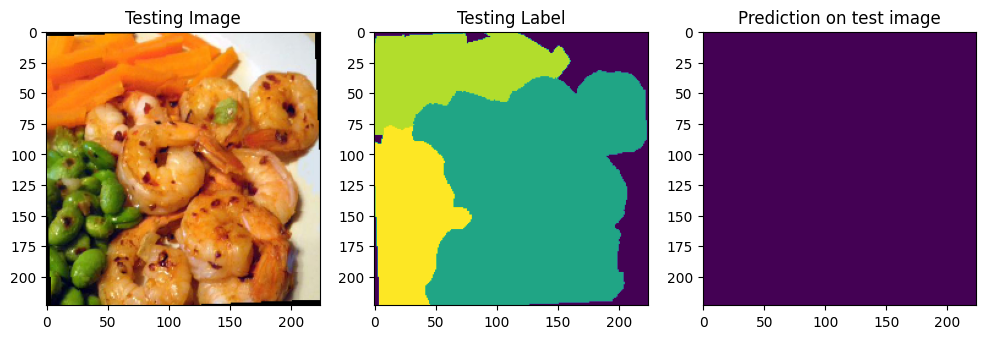

In [ ]:
import random

# Load the pre-trained segmentation model
state_dict = torch.load('/content/gdrive/MyDrive/Thesis_deeplearning_models/deeplabv3_resnet101_v30_6.pth', map_location=torch.device('cpu') )

# Set the model to evaluation mode
#model = model
state_dict_real = state_dict['state_dict']
model.load_state_dict(state_dict_real)
model.eval()

# loader
test_X, test_y = next(iter(test_loader))
test_image = test_X[1]
ground_truth = test_y[1]

print("test image shape", test_image.shape)
print("ground_truth shape ", ground_truth.shape)

# Prepare to pass to the model
test_image = test_image.unsqueeze(dim=0)
print("timage", test_image.shape)

# Convert the image to a PyTorch tensor
img_tensor = test_image.cuda()
#img_tensor = test_image

# Predict the segmentation mask
with torch.no_grad():
    output = model.forward(img_tensor)

print("output shape", output.shape)

# Remove the batch size dimension
prediction = output.squeeze()
# Apply softmax on output logits
#prediction = F.softmax(prediction, dim=0)
# Classes dimension becomes first so dim=0
max_values = torch.argmax(prediction, dim=0)
prediction = max_values


# Prediction gives a 256*256 output
print("prediction", prediction.shape)

# Pass the prediction to the cpu
prediction = prediction.cpu()
print(prediction)
#-----

# Preparation test image and ground_truth
test_image = test_image.squeeze()
#test_image = test_image.permute(1, 2, 0)
print("test_image+", test_image.shape)
ground_truth = ground_truth.squeeze()

ground_truth = 255 * ground_truth
ground_truth = ground_truth.long()

print(ground_truth)

"""
--------------- METRICS --------------
"""

tp, fp, fn, tn = smp.metrics.get_stats(prediction, ground_truth, mode='multiclass', num_classes=104)
iiou_acc = smp.metrics.iou_score(tp, fp, fn, tn, reduction="micro").item()
ddice_acc = smp.metrics.f1_score(tp, fp, fn, tn, reduction="micro").item()
aacc = smp.metrics.accuracy(tp, fp, fn, tn, reduction="macro").item()



# Calculate pixel accuracy
print("SMP Pixel Accuracy", aacc)
print("SMP Intersection over union", iiou_acc)
print("SMP Dice coefficient metric", ddice_acc)

# Calculate pixel accuracy
print("Pixel Accuracy", calculate_pixel_accuracy(ground_truth, prediction))
print("Intersection over union", calculate_iou(ground_truth, prediction))
print("Dice coefficient metric", dice_coefficient(ground_truth, prediction))


img_unnorm = UnNormalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))

test_image = img_unnorm(test_image)

test_image = test_image.permute(1, 2, 0)

# normalize the tensor values to the range [0, 255]
test_image = test_image * 255.0

# convert the tensor to a numpy array
test_image = test_image.clamp(0, 255).byte().numpy()

## PLOT

plt.figure(figsize=(12, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_image)
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth)
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(prediction)
plt.show()

